## LSTM For each SCALE

## Original

## Variogram 0.2 Non-scaled

In [1215]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse

In [1216]:
training_set = pd.read_csv('datasets/orig_v1_0.csv')

In [1217]:
training_set = training_set.iloc[:,2:3].values

In [1218]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [1219]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [1220]:
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05728
Epoch: 100, loss: 0.04096
Epoch: 200, loss: 0.04080
Epoch: 300, loss: 0.04069
Epoch: 400, loss: 0.04042
Epoch: 500, loss: 0.03770
Epoch: 600, loss: 0.03512
Epoch: 700, loss: 0.03145
Epoch: 800, loss: 0.02980
Epoch: 900, loss: 0.02841
Epoch: 1000, loss: 0.02782
Epoch: 1100, loss: 0.02731
Epoch: 1200, loss: 0.02708
Epoch: 1300, loss: 0.02685
Epoch: 1400, loss: 0.02668
Epoch: 1500, loss: 0.02656
Epoch: 1600, loss: 0.02644
Epoch: 1700, loss: 0.02628
Epoch: 1800, loss: 0.02617
Epoch: 1900, loss: 0.02606


Text(0, 0.5, 'Loss')

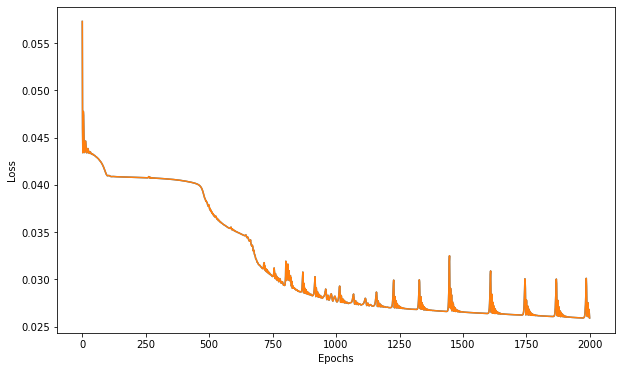

In [1221]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

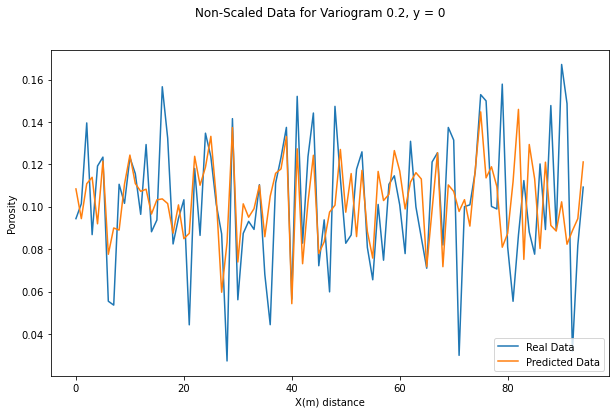

In [1222]:
lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 0')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.422838327623891, pvalue=1.965479402384802e-05)
STD: 0.028193532
MSE: 0.0007968776


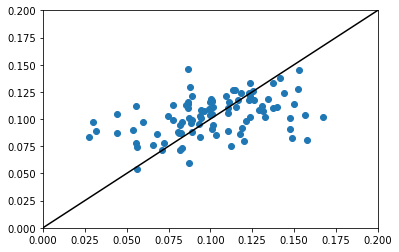

In [1223]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.58213
Epoch: 100, loss: 0.04828
Epoch: 200, loss: 0.04811
Epoch: 300, loss: 0.04765
Epoch: 400, loss: 0.04715
Epoch: 500, loss: 0.04686
Epoch: 600, loss: 0.04649
Epoch: 700, loss: 0.04591
Epoch: 800, loss: 0.04442
Epoch: 900, loss: 0.04069
Epoch: 1000, loss: 0.03304
Epoch: 1100, loss: 0.03038
Epoch: 1200, loss: 0.02878
Epoch: 1300, loss: 0.02781
Epoch: 1400, loss: 0.02617
Epoch: 1500, loss: 0.02410
Epoch: 1600, loss: 0.02258
Epoch: 1700, loss: 0.01998
Epoch: 1800, loss: 0.01892
Epoch: 1900, loss: 0.01807


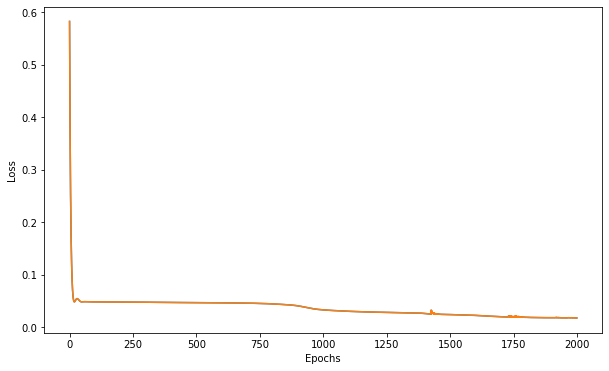

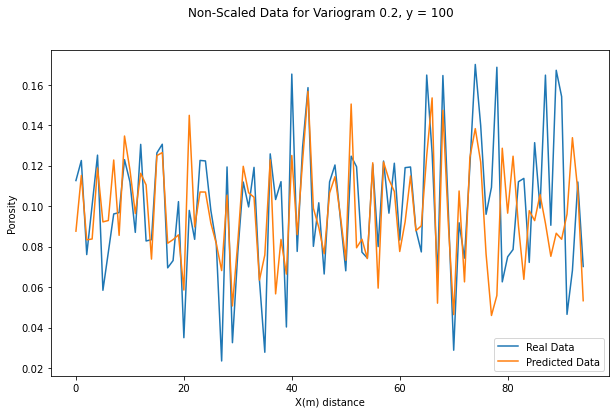

In [1224]:
training_set = pd.read_csv('datasets/orig_v1_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 100')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5327208691698105, pvalue=2.7447091225819553e-08)
STD: 0.029216038
MSE: 0.0008635208


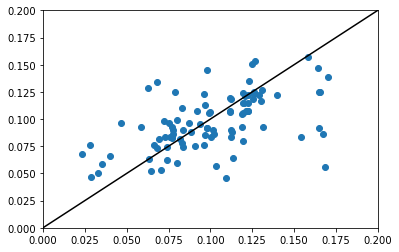

In [1225]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.09592
Epoch: 100, loss: 0.01443
Epoch: 200, loss: 0.01441
Epoch: 300, loss: 0.01439
Epoch: 400, loss: 0.01436
Epoch: 500, loss: 0.01434
Epoch: 600, loss: 0.01431
Epoch: 700, loss: 0.01426
Epoch: 800, loss: 0.01418
Epoch: 900, loss: 0.01405
Epoch: 1000, loss: 0.01391
Epoch: 1100, loss: 0.01371
Epoch: 1200, loss: 0.01346
Epoch: 1300, loss: 0.01333
Epoch: 1400, loss: 0.01331
Epoch: 1500, loss: 0.01329
Epoch: 1600, loss: 0.01328
Epoch: 1700, loss: 0.01327
Epoch: 1800, loss: 0.01325
Epoch: 1900, loss: 0.01319


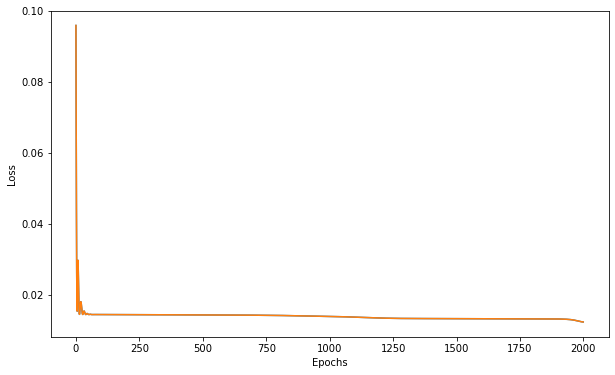

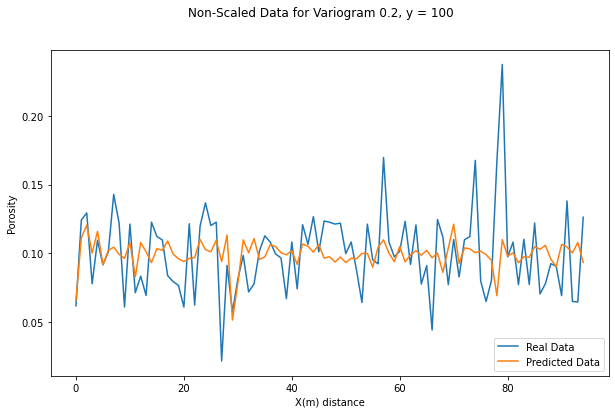

In [1226]:
training_set = pd.read_csv('datasets/orig_v1_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 100')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.24357154662979472, pvalue=0.017380676190059535)
STD: 0.02918989
MSE: 0.00085256516


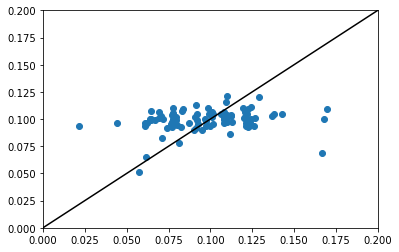

In [1227]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.79992
Epoch: 100, loss: 0.04409
Epoch: 200, loss: 0.04382
Epoch: 300, loss: 0.04373
Epoch: 400, loss: 0.04366
Epoch: 500, loss: 0.04356
Epoch: 600, loss: 0.04284
Epoch: 700, loss: 0.03961
Epoch: 800, loss: 0.03802
Epoch: 900, loss: 0.03743
Epoch: 1000, loss: 0.03653
Epoch: 1100, loss: 0.03468
Epoch: 1200, loss: 0.03265
Epoch: 1300, loss: 0.03028
Epoch: 1400, loss: 0.02860
Epoch: 1500, loss: 0.02755
Epoch: 1600, loss: 0.02731
Epoch: 1700, loss: 0.02665
Epoch: 1800, loss: 0.02633
Epoch: 1900, loss: 0.02639


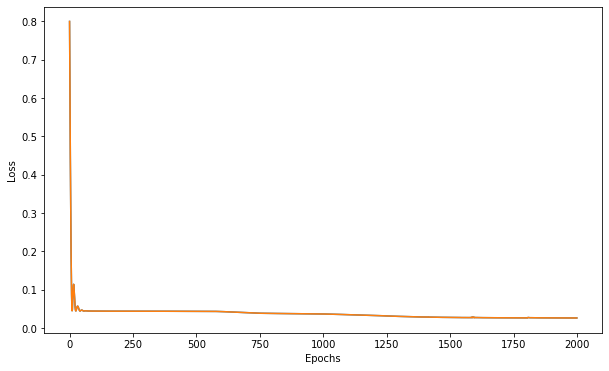

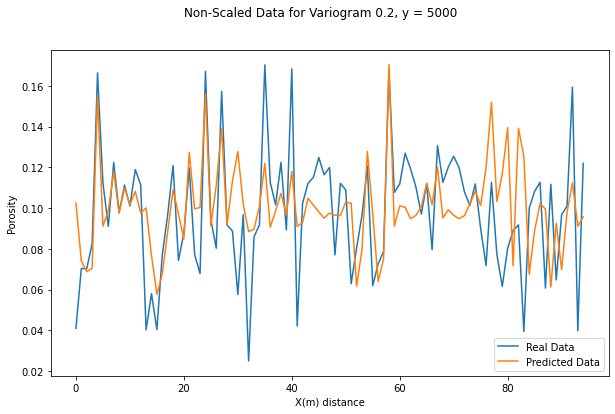

In [1228]:
training_set = pd.read_csv('datasets/orig_v1_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 5000')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.44791578502047225, pvalue=5.327254172569915e-06)
STD: 0.02809839
MSE: 0.00079624803


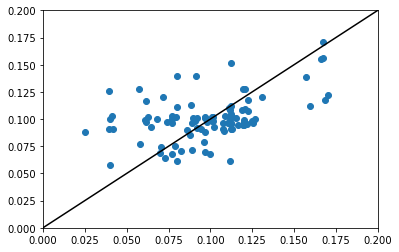

In [1229]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.03257
Epoch: 100, loss: 0.02266
Epoch: 200, loss: 0.02249
Epoch: 300, loss: 0.02192
Epoch: 400, loss: 0.02107
Epoch: 500, loss: 0.02061
Epoch: 600, loss: 0.02008
Epoch: 700, loss: 0.01984
Epoch: 800, loss: 0.01970
Epoch: 900, loss: 0.01954
Epoch: 1000, loss: 0.01912
Epoch: 1100, loss: 0.02186
Epoch: 1200, loss: 0.01750
Epoch: 1300, loss: 0.01702
Epoch: 1400, loss: 0.01577
Epoch: 1500, loss: 0.01508
Epoch: 1600, loss: 0.01465
Epoch: 1700, loss: 0.01419
Epoch: 1800, loss: 0.01361
Epoch: 1900, loss: 0.01317


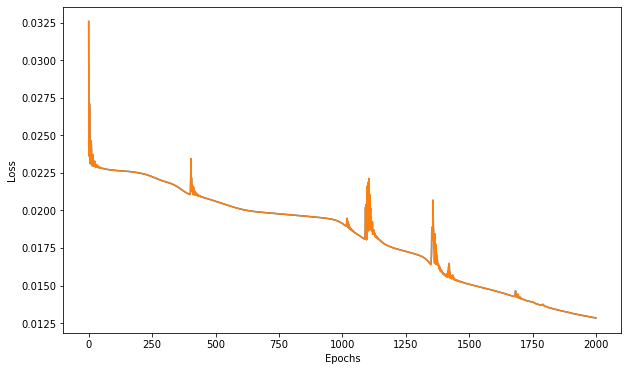

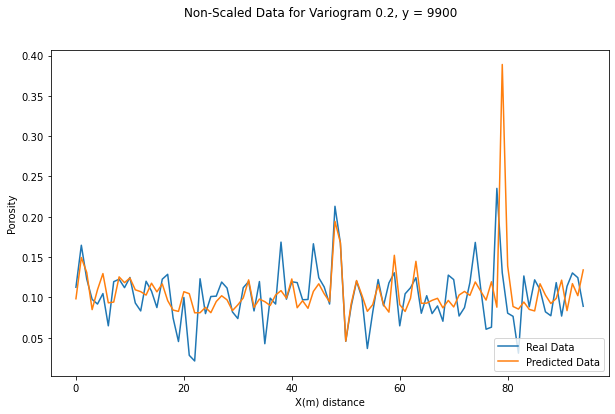

In [1230]:
training_set = pd.read_csv('datasets/orig_v1_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Non-Scaled Data for Variogram 0.2, y = 9900')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.34660289893421614, pvalue=0.0005798791805257207)
STD: 0.040063072
MSE: 0.0016151834


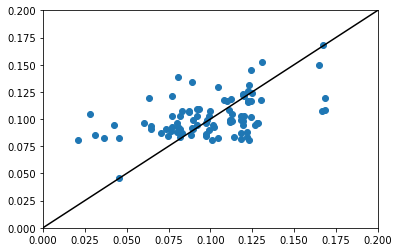

In [1231]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.398729885475637
Average MSE:  0.0009848790243268013


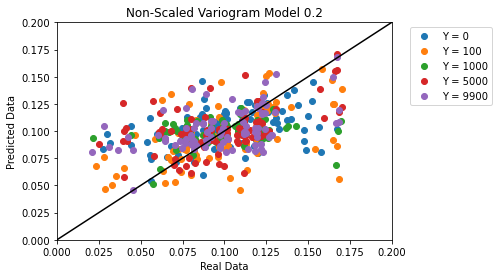

In [1232]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(["0", "100", "5000", "9900"], loc ="upper left")
#print(new5[0])

In [1233]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real1 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

## Variogram 0.4 Non-scaled

Epoch: 0, loss: 0.63435
Epoch: 100, loss: 0.02597
Epoch: 200, loss: 0.01232
Epoch: 300, loss: 0.00475
Epoch: 400, loss: 0.00319
Epoch: 500, loss: 0.00239
Epoch: 600, loss: 0.00219
Epoch: 700, loss: 0.00209
Epoch: 800, loss: 0.00203
Epoch: 900, loss: 0.00197
Epoch: 1000, loss: 0.00190
Epoch: 1100, loss: 0.00182
Epoch: 1200, loss: 0.00177
Epoch: 1300, loss: 0.00175
Epoch: 1400, loss: 0.00173
Epoch: 1500, loss: 0.00171
Epoch: 1600, loss: 0.00169
Epoch: 1700, loss: 0.00167
Epoch: 1800, loss: 0.00164
Epoch: 1900, loss: 0.00161


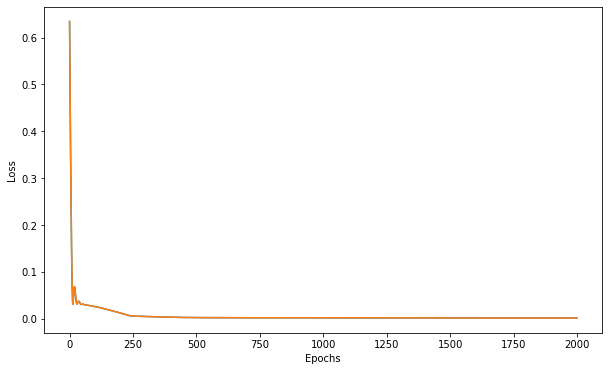

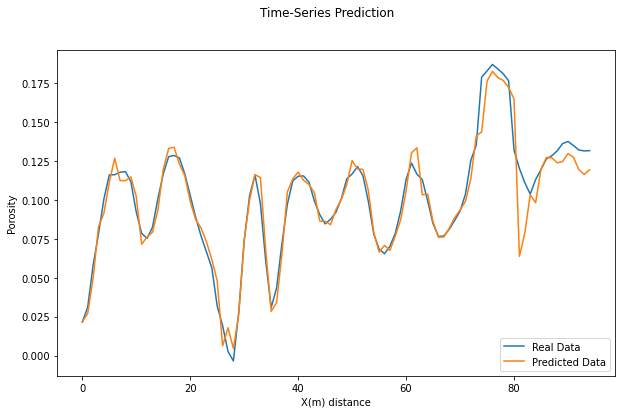

In [1234]:
training_set = pd.read_csv('datasets/orig_sim2_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9597143690338581, pvalue=4.57556997150183e-53)
STD: 0.010535404
MSE: 0.00011394319


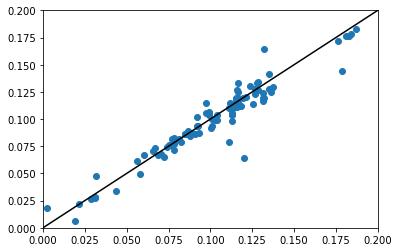

In [1235]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.03235
Epoch: 100, loss: 0.00234
Epoch: 200, loss: 0.00215
Epoch: 300, loss: 0.00212
Epoch: 400, loss: 0.00209
Epoch: 500, loss: 0.00206
Epoch: 600, loss: 0.00202
Epoch: 700, loss: 0.00198
Epoch: 800, loss: 0.00197
Epoch: 900, loss: 0.00191
Epoch: 1000, loss: 0.00188
Epoch: 1100, loss: 0.00185
Epoch: 1200, loss: 0.00182
Epoch: 1300, loss: 0.00179
Epoch: 1400, loss: 0.00177
Epoch: 1500, loss: 0.00174
Epoch: 1600, loss: 0.00177
Epoch: 1700, loss: 0.00168
Epoch: 1800, loss: 0.00181
Epoch: 1900, loss: 0.00164


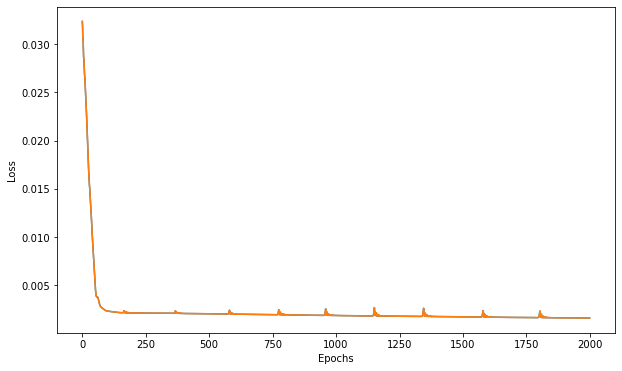

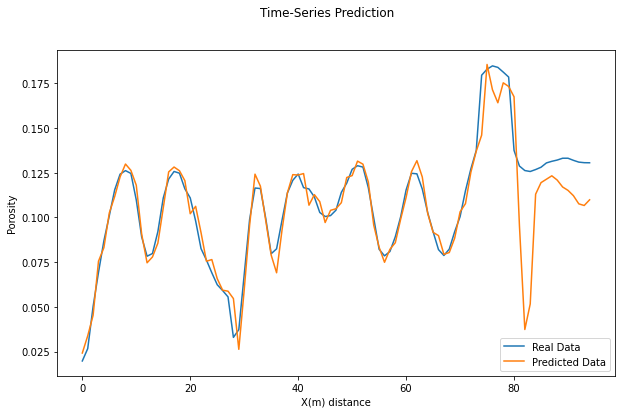

In [1236]:
training_set = pd.read_csv('datasets/orig_sim2_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8910042289445396, pvalue=1.1782086581141616e-33)
STD: 0.014836663
MSE: 0.0002364057


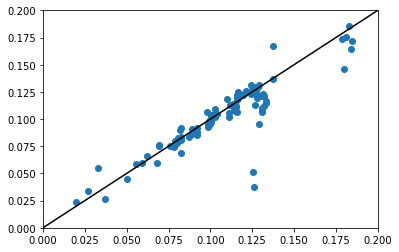

In [1237]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.51227
Epoch: 100, loss: 0.03098
Epoch: 200, loss: 0.01678
Epoch: 300, loss: 0.00799
Epoch: 400, loss: 0.00596
Epoch: 500, loss: 0.00489
Epoch: 600, loss: 0.00419
Epoch: 700, loss: 0.00371
Epoch: 800, loss: 0.00337
Epoch: 900, loss: 0.00311
Epoch: 1000, loss: 0.00290
Epoch: 1100, loss: 0.00272
Epoch: 1200, loss: 0.00256
Epoch: 1300, loss: 0.00243
Epoch: 1400, loss: 0.00234
Epoch: 1500, loss: 0.00229
Epoch: 1600, loss: 0.00223
Epoch: 1700, loss: 0.00216
Epoch: 1800, loss: 0.00210
Epoch: 1900, loss: 0.00208


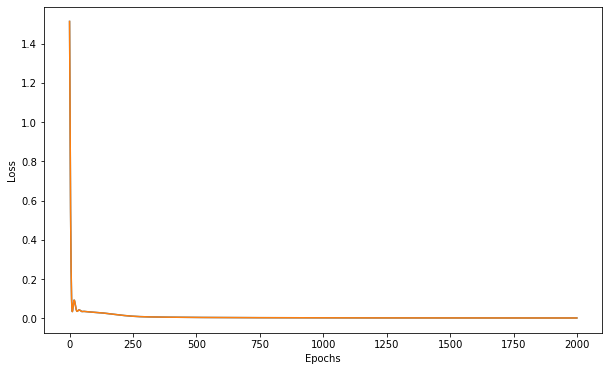

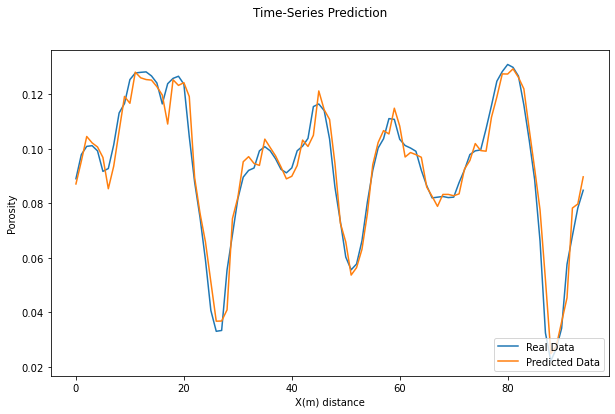

In [1238]:
training_set = pd.read_csv('datasets/orig_sim2_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9770008576564442, pvalue=3.238388159260515e-64)
STD: 0.0054881186
MSE: 3.0230673e-05


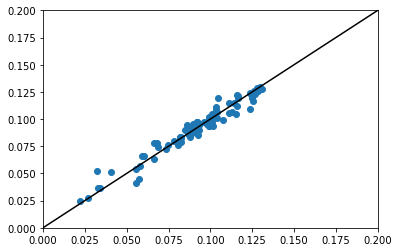

In [1239]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.36123
Epoch: 100, loss: 0.00397
Epoch: 200, loss: 0.00354
Epoch: 300, loss: 0.00242
Epoch: 400, loss: 0.00237
Epoch: 500, loss: 0.00234
Epoch: 600, loss: 0.00228
Epoch: 700, loss: 0.00223
Epoch: 800, loss: 0.00216
Epoch: 900, loss: 0.00210
Epoch: 1000, loss: 0.00205
Epoch: 1100, loss: 0.00200
Epoch: 1200, loss: 0.00194
Epoch: 1300, loss: 0.00190
Epoch: 1400, loss: 0.00187
Epoch: 1500, loss: 0.00185
Epoch: 1600, loss: 0.00183
Epoch: 1700, loss: 0.00182
Epoch: 1800, loss: 0.00180
Epoch: 1900, loss: 0.00179


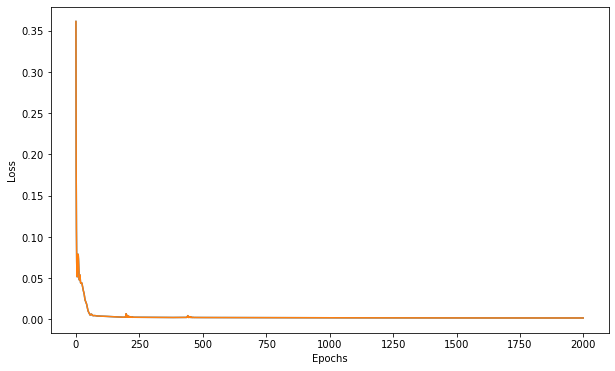

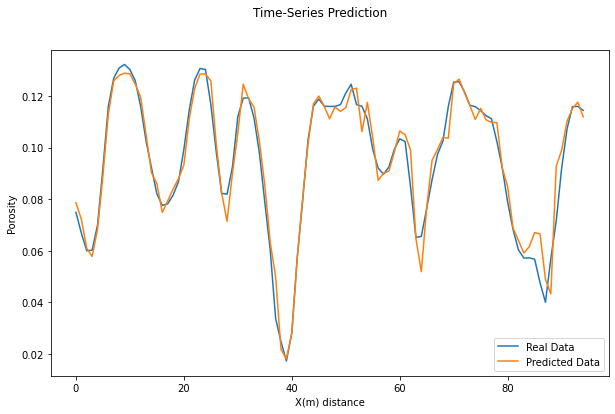

In [1240]:
training_set = pd.read_csv('datasets/orig_sim2_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9772889119300552, pvalue=1.8139230599020133e-64)
STD: 0.0057235444
MSE: 3.3381424e-05


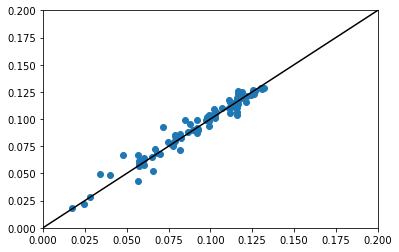

In [1241]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.86485
Epoch: 100, loss: 0.04258
Epoch: 200, loss: 0.00324
Epoch: 300, loss: 0.00184
Epoch: 400, loss: 0.00155
Epoch: 500, loss: 0.00148
Epoch: 600, loss: 0.00143
Epoch: 700, loss: 0.00139
Epoch: 800, loss: 0.00137
Epoch: 900, loss: 0.00136
Epoch: 1000, loss: 0.00136
Epoch: 1100, loss: 0.00136
Epoch: 1200, loss: 0.00135
Epoch: 1300, loss: 0.00135
Epoch: 1400, loss: 0.00135
Epoch: 1500, loss: 0.00134
Epoch: 1600, loss: 0.00134
Epoch: 1700, loss: 0.00134
Epoch: 1800, loss: 0.00134
Epoch: 1900, loss: 0.00133


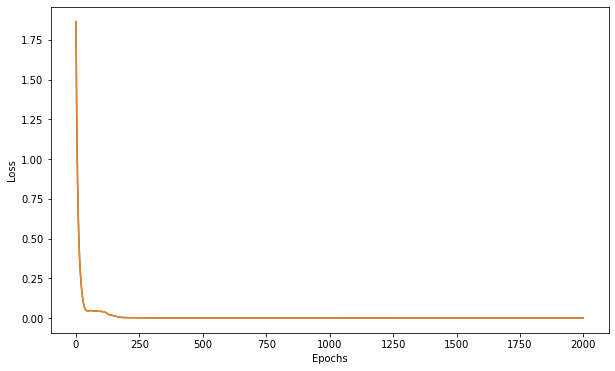

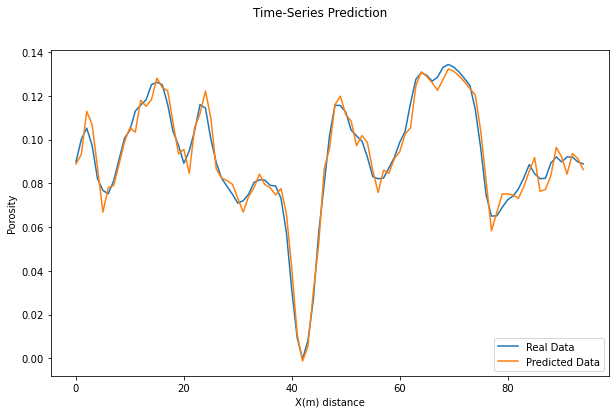

In [1242]:
training_set = pd.read_csv('datasets/orig_sim2_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9829457295902811, pvalue=3.380932472346639e-70)
STD: 0.0048777815
MSE: 2.3805802e-05


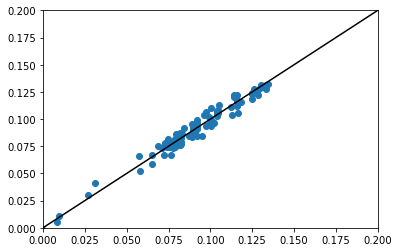

In [1243]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9575908194310356
Average MSE:  8.755335584282875e-05


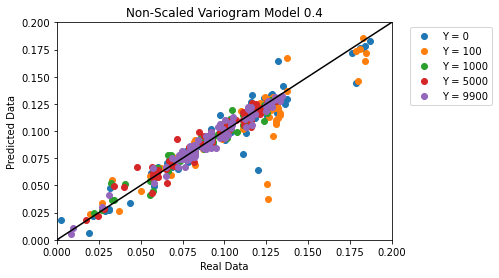

In [1244]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(["0", "100", "5000", "9900"], loc ="upper left")
#print(new5[0])

In [1245]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real2 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

## Variogram 0.6 Non-scaled

Epoch: 0, loss: 0.18918
Epoch: 100, loss: 0.00562
Epoch: 200, loss: 0.00139
Epoch: 300, loss: 0.00074
Epoch: 400, loss: 0.00070
Epoch: 500, loss: 0.00069
Epoch: 600, loss: 0.00069
Epoch: 700, loss: 0.00068
Epoch: 800, loss: 0.00068
Epoch: 900, loss: 0.00067
Epoch: 1000, loss: 0.00066
Epoch: 1100, loss: 0.00065
Epoch: 1200, loss: 0.00065
Epoch: 1300, loss: 0.00064
Epoch: 1400, loss: 0.00063
Epoch: 1500, loss: 0.00063
Epoch: 1600, loss: 0.00062
Epoch: 1700, loss: 0.00061
Epoch: 1800, loss: 0.00061
Epoch: 1900, loss: 0.00060


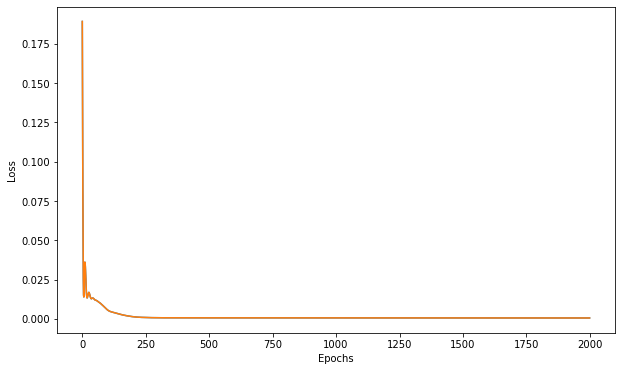

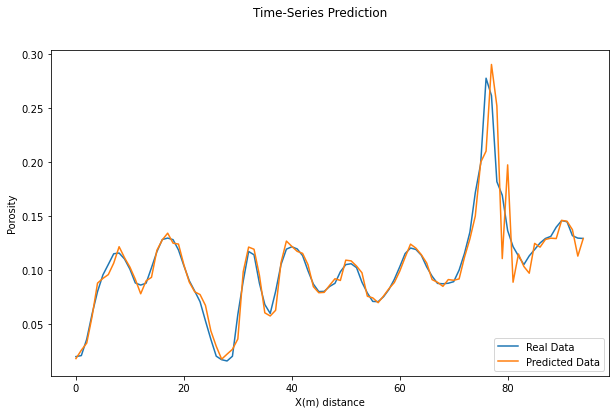

In [1246]:
training_set = pd.read_csv('datasets/orig_sim3_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.935224329507013, pvalue=1.0200532779123867e-43)
STD: 0.015352209
MSE: 0.00023584253


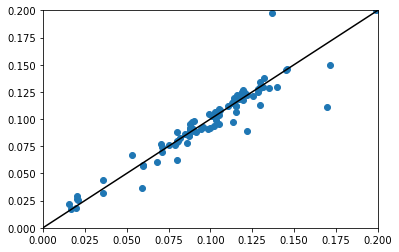

In [1247]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.18980
Epoch: 100, loss: 0.00508
Epoch: 200, loss: 0.00102
Epoch: 300, loss: 0.00073
Epoch: 400, loss: 0.00070
Epoch: 500, loss: 0.00070
Epoch: 600, loss: 0.00069
Epoch: 700, loss: 0.00069
Epoch: 800, loss: 0.00069
Epoch: 900, loss: 0.00068
Epoch: 1000, loss: 0.00068
Epoch: 1100, loss: 0.00068
Epoch: 1200, loss: 0.00067
Epoch: 1300, loss: 0.00067
Epoch: 1400, loss: 0.00067
Epoch: 1500, loss: 0.00067
Epoch: 1600, loss: 0.00066
Epoch: 1700, loss: 0.00067
Epoch: 1800, loss: 0.00066
Epoch: 1900, loss: 0.00066


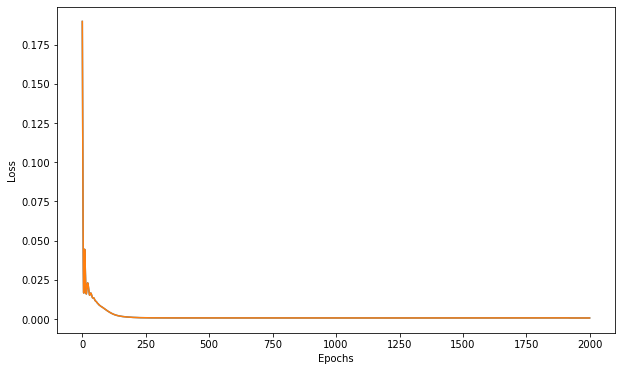

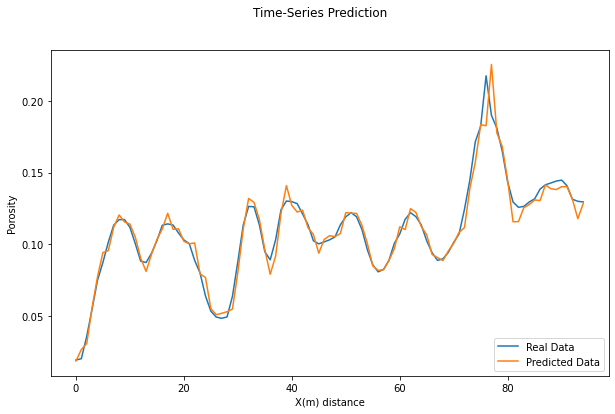

In [1248]:
training_set = pd.read_csv('datasets/orig_sim3_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9756066574587139, pvalue=4.844106877588942e-63)
STD: 0.0072375108
MSE: 5.2792922e-05


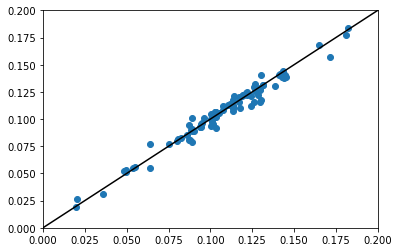

In [1249]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.66869
Epoch: 100, loss: 0.02608
Epoch: 200, loss: 0.00260
Epoch: 300, loss: 0.00235
Epoch: 400, loss: 0.00224
Epoch: 500, loss: 0.00218
Epoch: 600, loss: 0.00210
Epoch: 700, loss: 0.00195
Epoch: 800, loss: 0.00176
Epoch: 900, loss: 0.00151
Epoch: 1000, loss: 0.00148
Epoch: 1100, loss: 0.00147
Epoch: 1200, loss: 0.00147
Epoch: 1300, loss: 0.00146
Epoch: 1400, loss: 0.00146
Epoch: 1500, loss: 0.00146
Epoch: 1600, loss: 0.00146
Epoch: 1700, loss: 0.00145
Epoch: 1800, loss: 0.00145
Epoch: 1900, loss: 0.00145


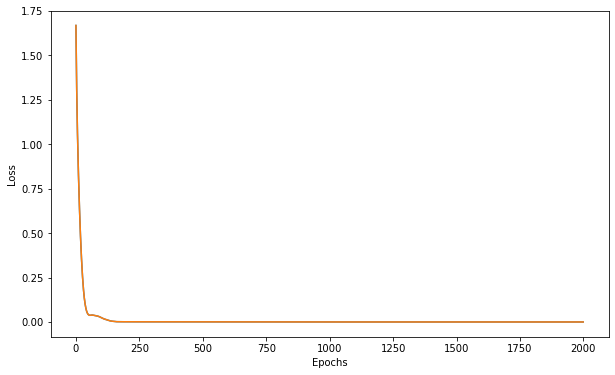

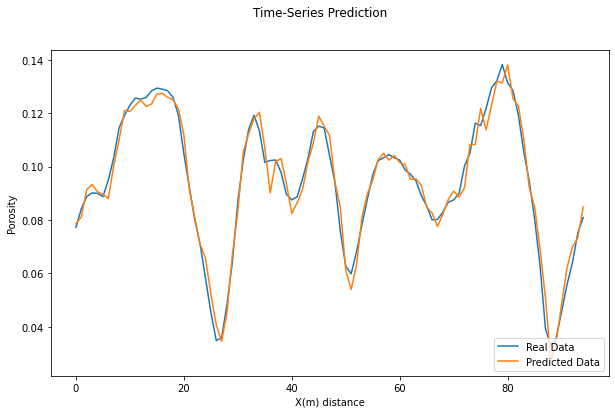

In [1250]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.985175006791532, pvalue=5.269480378209286e-73)
STD: 0.004349326
MSE: 1.896448e-05


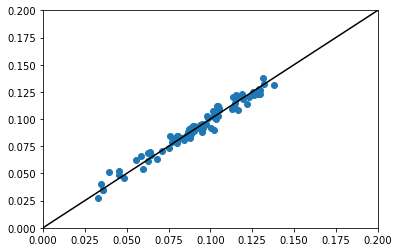

In [1251]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.40118
Epoch: 100, loss: 0.00423
Epoch: 200, loss: 0.00208
Epoch: 300, loss: 0.00151
Epoch: 400, loss: 0.00149
Epoch: 500, loss: 0.00149
Epoch: 600, loss: 0.00148
Epoch: 700, loss: 0.00147
Epoch: 800, loss: 0.00147
Epoch: 900, loss: 0.00146
Epoch: 1000, loss: 0.00146
Epoch: 1100, loss: 0.00145
Epoch: 1200, loss: 0.00145
Epoch: 1300, loss: 0.00152
Epoch: 1400, loss: 0.00144
Epoch: 1500, loss: 0.00144
Epoch: 1600, loss: 0.00158
Epoch: 1700, loss: 0.00143
Epoch: 1800, loss: 0.00143
Epoch: 1900, loss: 0.00148


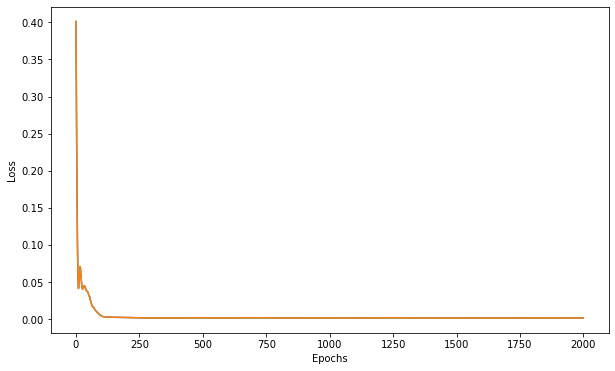

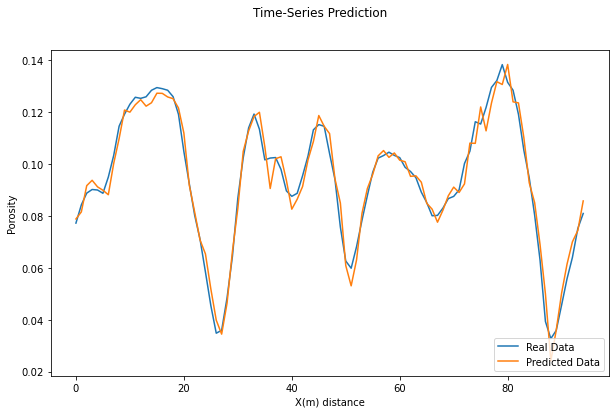

In [1252]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9847348113159718, pvalue=2.0341642129521368e-72)
STD: 0.00441002
MSE: 1.9489944e-05


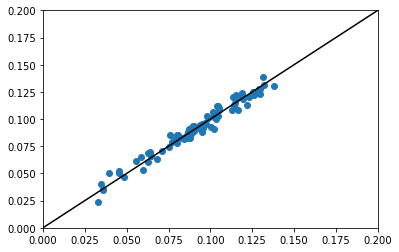

In [1253]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.55499
Epoch: 100, loss: 0.01711
Epoch: 200, loss: 0.00573
Epoch: 300, loss: 0.00272
Epoch: 400, loss: 0.00192
Epoch: 500, loss: 0.00185
Epoch: 600, loss: 0.00181
Epoch: 700, loss: 0.00177
Epoch: 800, loss: 0.00171
Epoch: 900, loss: 0.00162
Epoch: 1000, loss: 0.00155
Epoch: 1100, loss: 0.00151
Epoch: 1200, loss: 0.00148
Epoch: 1300, loss: 0.00146
Epoch: 1400, loss: 0.00145
Epoch: 1500, loss: 0.00144
Epoch: 1600, loss: 0.00143
Epoch: 1700, loss: 0.00142
Epoch: 1800, loss: 0.00141
Epoch: 1900, loss: 0.00140


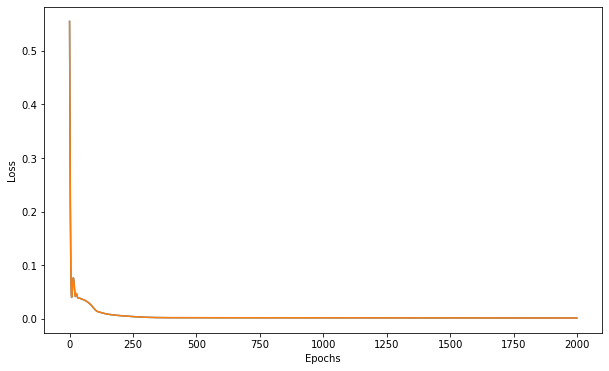

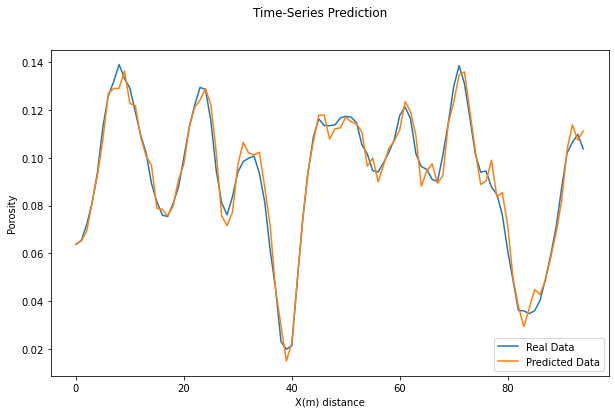

In [1254]:
training_set = pd.read_csv('datasets/orig_sim3_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9858404990949362, pvalue=6.320256436361446e-74)
STD: 0.00470909
MSE: 2.2319455e-05


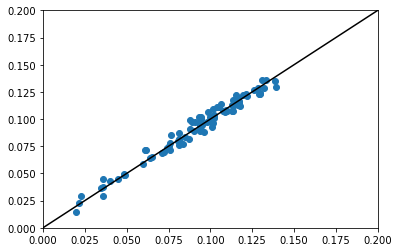

In [1255]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.34957
Epoch: 100, loss: 0.00453
Epoch: 200, loss: 0.00250
Epoch: 300, loss: 0.00240
Epoch: 400, loss: 0.00236
Epoch: 500, loss: 0.00216
Epoch: 600, loss: 0.00146
Epoch: 700, loss: 0.00145
Epoch: 800, loss: 0.00144
Epoch: 900, loss: 0.00143
Epoch: 1000, loss: 0.00143
Epoch: 1100, loss: 0.00142
Epoch: 1200, loss: 0.00141
Epoch: 1300, loss: 0.00140
Epoch: 1400, loss: 0.00140
Epoch: 1500, loss: 0.00139
Epoch: 1600, loss: 0.00138
Epoch: 1700, loss: 0.00138
Epoch: 1800, loss: 0.00138
Epoch: 1900, loss: 0.00137


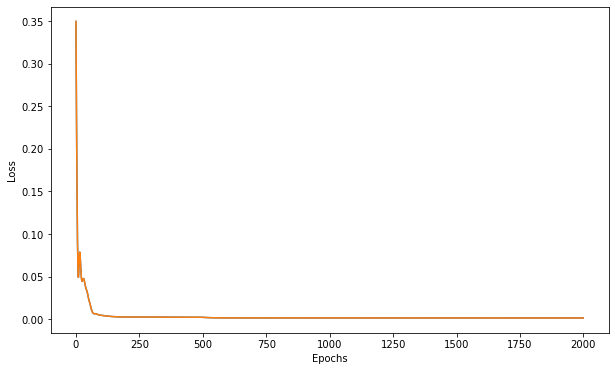

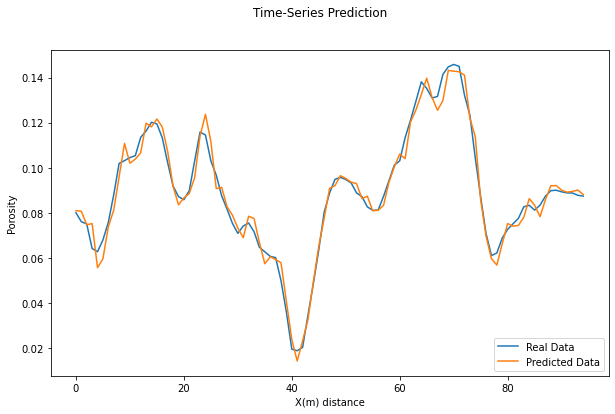

In [1256]:
training_set = pd.read_csv('datasets/orig_sim3_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9865777763232791, pvalue=5.345911339681718e-75)
STD: 0.0043687476
MSE: 1.9095334e-05


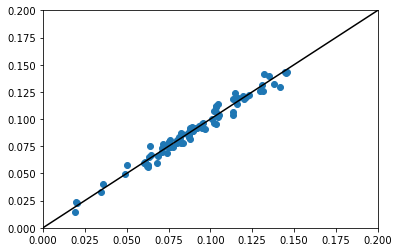

In [1257]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9735968147399827
Average MSE:  6.990803522057831e-05


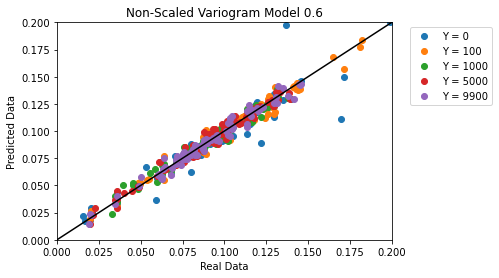

In [1258]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(["0", "100", "5000", "9900"], loc ="upper left")
#print(new5[0])

In [1259]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real3 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

## Variogram 0.8 Non-scaled

Epoch: 0, loss: 0.02061
Epoch: 100, loss: 0.00201
Epoch: 200, loss: 0.00110
Epoch: 300, loss: 0.00079
Epoch: 400, loss: 0.00074
Epoch: 500, loss: 0.00072
Epoch: 600, loss: 0.00070
Epoch: 700, loss: 0.00068
Epoch: 800, loss: 0.00067
Epoch: 900, loss: 0.00067
Epoch: 1000, loss: 0.00066
Epoch: 1100, loss: 0.00065
Epoch: 1200, loss: 0.00064
Epoch: 1300, loss: 0.00063
Epoch: 1400, loss: 0.00061
Epoch: 1500, loss: 0.00060
Epoch: 1600, loss: 0.00058
Epoch: 1700, loss: 0.00056
Epoch: 1800, loss: 0.00055
Epoch: 1900, loss: 0.00054


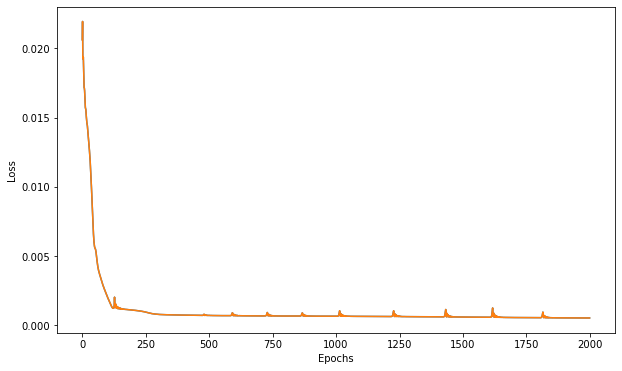

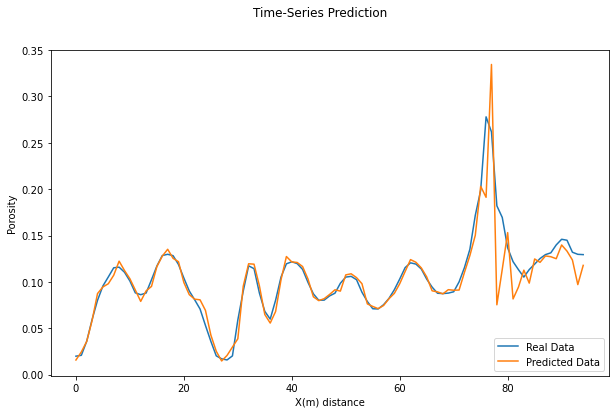

In [1260]:
training_set = pd.read_csv('datasets/orig_sim4_0.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.898957533870357, pvalue=4.188952429377096e-35)
STD: 0.018718818
MSE: 0.000361426


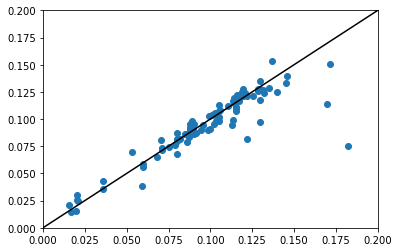

In [1261]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.75995
Epoch: 100, loss: 0.01410
Epoch: 200, loss: 0.00272
Epoch: 300, loss: 0.00092
Epoch: 400, loss: 0.00072
Epoch: 500, loss: 0.00071
Epoch: 600, loss: 0.00071
Epoch: 700, loss: 0.00070
Epoch: 800, loss: 0.00070
Epoch: 900, loss: 0.00069
Epoch: 1000, loss: 0.00069
Epoch: 1100, loss: 0.00069
Epoch: 1200, loss: 0.00069
Epoch: 1300, loss: 0.00068
Epoch: 1400, loss: 0.00068
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00071
Epoch: 1700, loss: 0.00067
Epoch: 1800, loss: 0.00067
Epoch: 1900, loss: 0.00067


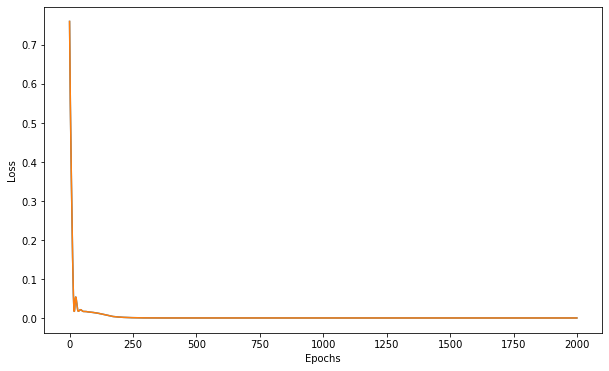

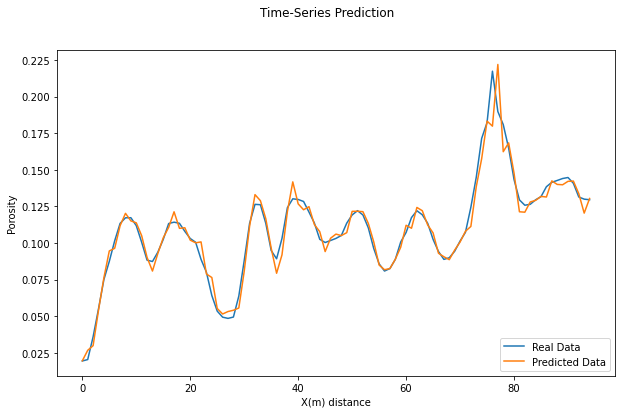

In [1262]:
training_set = pd.read_csv('datasets/orig_sim4_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9752865676899525, pvalue=8.817639112405254e-63)
STD: 0.0072824624
MSE: 5.329134e-05


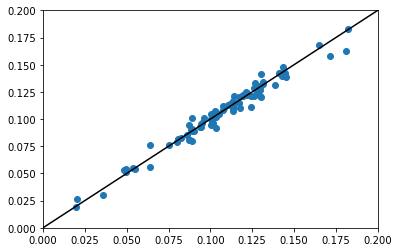

In [1263]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.51786
Epoch: 100, loss: 0.01185
Epoch: 200, loss: 0.00488
Epoch: 300, loss: 0.00293
Epoch: 400, loss: 0.00243
Epoch: 500, loss: 0.00228
Epoch: 600, loss: 0.00218
Epoch: 700, loss: 0.00211
Epoch: 800, loss: 0.00202
Epoch: 900, loss: 0.00189
Epoch: 1000, loss: 0.00169
Epoch: 1100, loss: 0.00150
Epoch: 1200, loss: 0.00148
Epoch: 1300, loss: 0.00148
Epoch: 1400, loss: 0.00147
Epoch: 1500, loss: 0.00147
Epoch: 1600, loss: 0.00146
Epoch: 1700, loss: 0.00146
Epoch: 1800, loss: 0.00146
Epoch: 1900, loss: 0.00146


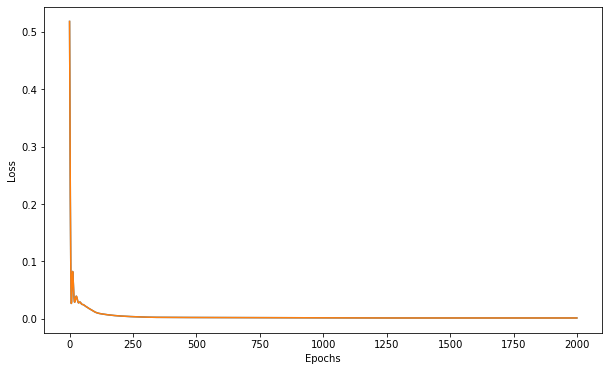

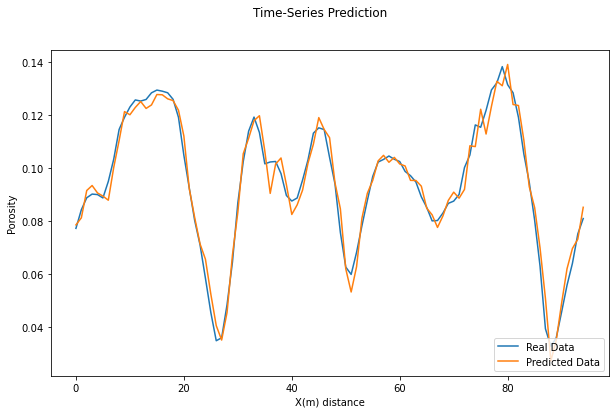

In [1264]:
training_set = pd.read_csv('datasets/orig_sim4_1000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9846471497239576, pvalue=2.64953596480705e-72)
STD: 0.0044241725
MSE: 1.9645031e-05


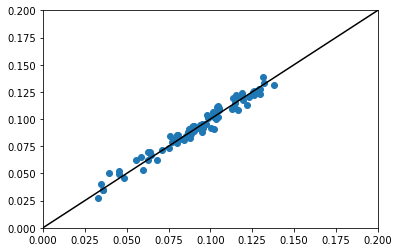

In [1265]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.08665
Epoch: 100, loss: 0.00202
Epoch: 200, loss: 0.00186
Epoch: 300, loss: 0.00181
Epoch: 400, loss: 0.00177
Epoch: 500, loss: 0.00173
Epoch: 600, loss: 0.00167
Epoch: 700, loss: 0.00158
Epoch: 800, loss: 0.00146
Epoch: 900, loss: 0.00141
Epoch: 1000, loss: 0.00137
Epoch: 1100, loss: 0.00136
Epoch: 1200, loss: 0.00134
Epoch: 1300, loss: 0.00133
Epoch: 1400, loss: 0.00132
Epoch: 1500, loss: 0.00130
Epoch: 1600, loss: 0.00129
Epoch: 1700, loss: 0.00128
Epoch: 1800, loss: 0.00132
Epoch: 1900, loss: 0.00127


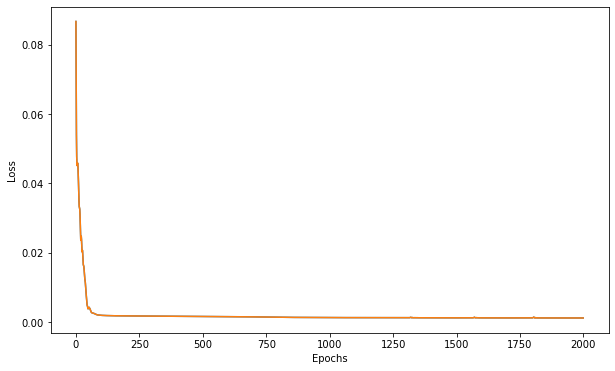

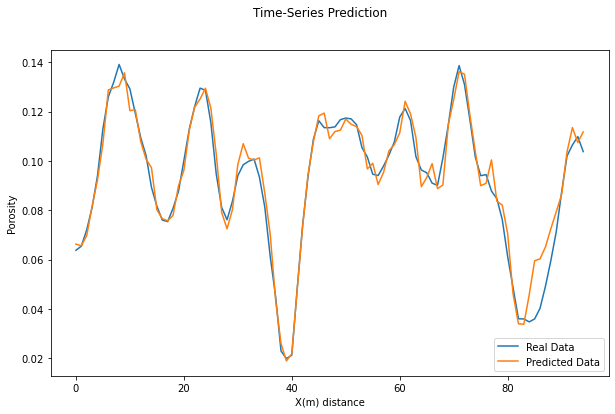

In [1266]:
training_set = pd.read_csv('datasets/orig_sim4_5000.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.978973463984777, pvalue=5.232631118215463e-66)
STD: 0.0058071385
MSE: 3.5364537e-05


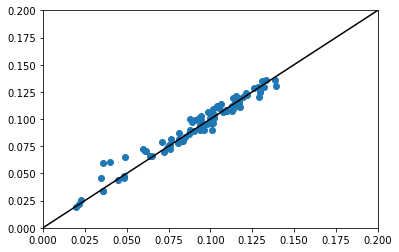

In [1267]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.50551
Epoch: 100, loss: 0.04102
Epoch: 200, loss: 0.01403
Epoch: 300, loss: 0.00598
Epoch: 400, loss: 0.00489
Epoch: 500, loss: 0.00405
Epoch: 600, loss: 0.00332
Epoch: 700, loss: 0.00263
Epoch: 800, loss: 0.00221
Epoch: 900, loss: 0.00206
Epoch: 1000, loss: 0.00196
Epoch: 1100, loss: 0.00188
Epoch: 1200, loss: 0.00180
Epoch: 1300, loss: 0.00174
Epoch: 1400, loss: 0.00169
Epoch: 1500, loss: 0.00164
Epoch: 1600, loss: 0.00161
Epoch: 1700, loss: 0.00158
Epoch: 1800, loss: 0.00156
Epoch: 1900, loss: 0.00154


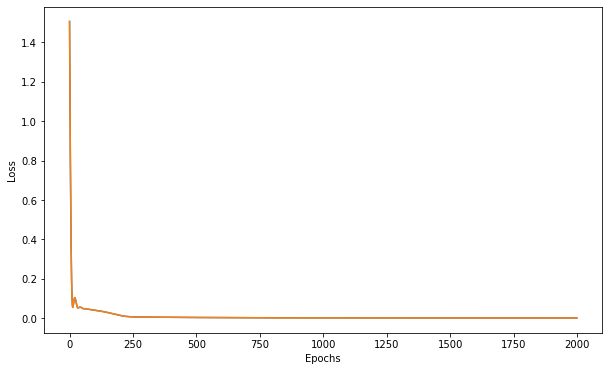

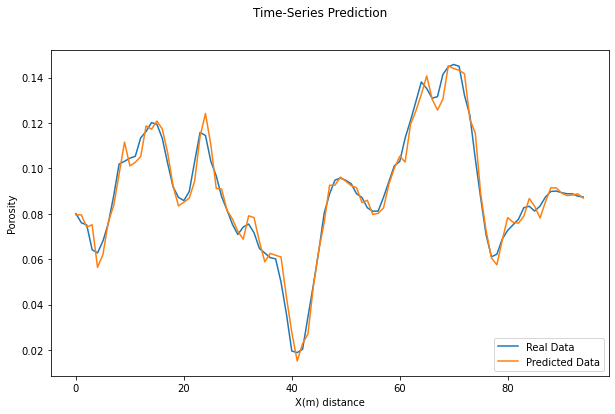

In [1268]:
training_set = pd.read_csv('datasets/orig_sim4_9900.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.03

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.985177840980176, pvalue=5.223171467687658e-73)
STD: 0.0045858505
MSE: 2.1030388e-05


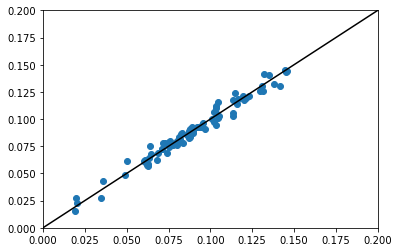

In [1269]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new5 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse5 = mse(dataY_plot[:,0], data_predict[:,0])
real_d5 = dataY_plot[:,0]
pred_d5 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.964608511249844
Average MSE:  9.815145749598741e-05


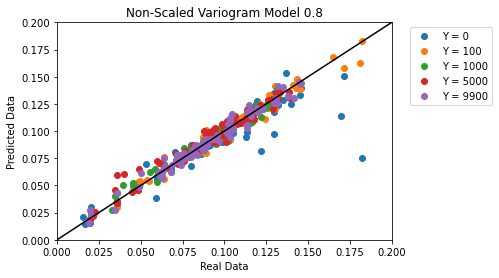

In [1270]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 0')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 100')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 1000')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 5000')
plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1271]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4, pred_d5))
real4 = np.concatenate((real_d1, real_d2, real_d3, real_d4, real_d5))

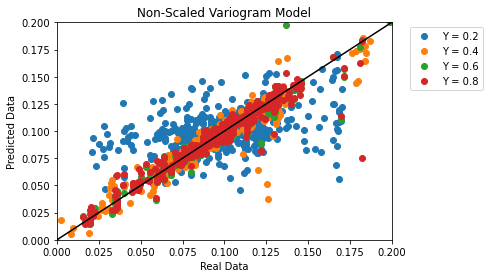

In [1272]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Non-Scaled Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Scaling 50

In [1273]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.Sigmoid()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        #out = nn.functional.dropout(out, p=self.p, training=True)
        #out = self.relu(out) #relu
        
        return out

Epoch: 0, loss: 0.04584
Epoch: 100, loss: 0.04110
Epoch: 200, loss: 0.02403
Epoch: 300, loss: 0.01685
Epoch: 400, loss: 0.01528
Epoch: 500, loss: 0.01473
Epoch: 600, loss: 0.01442
Epoch: 700, loss: 0.01439
Epoch: 800, loss: 0.01344
Epoch: 900, loss: 0.01713
Epoch: 1000, loss: 0.01325
Epoch: 1100, loss: 0.01277
Epoch: 1200, loss: 0.01348
Epoch: 1300, loss: 0.01263
Epoch: 1400, loss: 0.01236
Epoch: 1500, loss: 0.01262
Epoch: 1600, loss: 0.01220
Epoch: 1700, loss: 0.01411
Epoch: 1800, loss: 0.01236
Epoch: 1900, loss: 0.01177


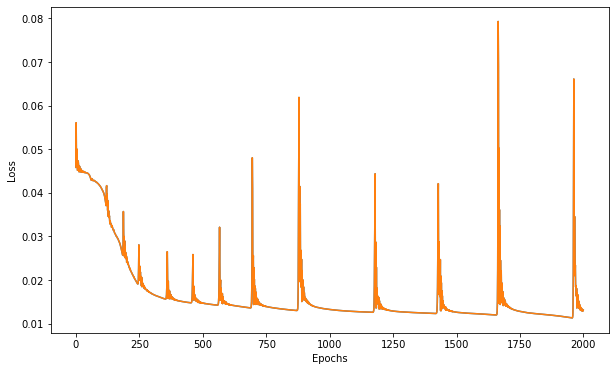

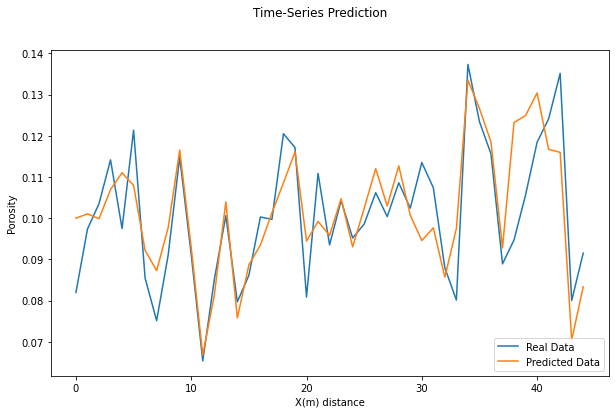

In [1274]:
training_set = pd.read_csv('datasets/scaled_v1_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7988688247567223, pvalue=4.810444524242882e-11)
STD: 0.009803137
MSE: 9.716956e-05


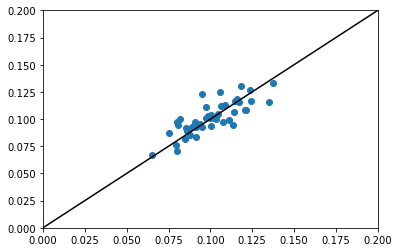

In [1275]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.09124
Epoch: 100, loss: 0.02916
Epoch: 200, loss: 0.02914
Epoch: 300, loss: 0.02909
Epoch: 400, loss: 0.02848
Epoch: 500, loss: 0.02795
Epoch: 600, loss: 0.02704
Epoch: 700, loss: 0.02265
Epoch: 800, loss: 0.01444
Epoch: 900, loss: 0.00842
Epoch: 1000, loss: 0.00784
Epoch: 1100, loss: 0.00754
Epoch: 1200, loss: 0.00677
Epoch: 1300, loss: 0.00550
Epoch: 1400, loss: 0.00511
Epoch: 1500, loss: 0.00739
Epoch: 1600, loss: 0.00476
Epoch: 1700, loss: 0.00462
Epoch: 1800, loss: 0.00448
Epoch: 1900, loss: 0.00463


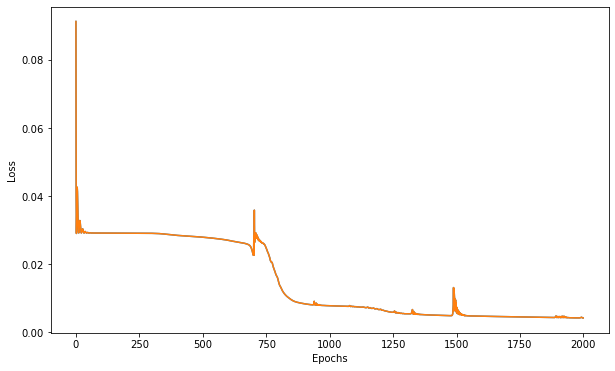

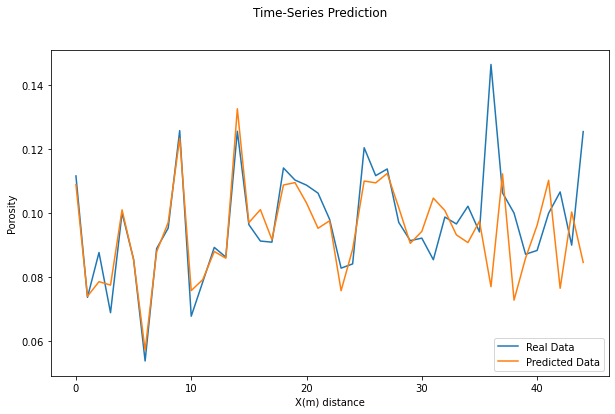

In [1276]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5870925768463857, pvalue=2.2437135618909764e-05)
STD: 0.014427865
MSE: 0.0002169308


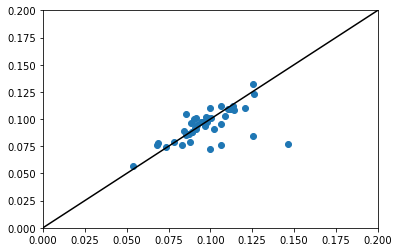

In [1277]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.07295
Epoch: 100, loss: 0.05597
Epoch: 200, loss: 0.05594
Epoch: 300, loss: 0.05584
Epoch: 400, loss: 0.05186
Epoch: 500, loss: 0.01481
Epoch: 600, loss: 0.01284
Epoch: 700, loss: 0.01118
Epoch: 800, loss: 0.01015
Epoch: 900, loss: 0.00981
Epoch: 1000, loss: 0.00938
Epoch: 1100, loss: 0.00836
Epoch: 1200, loss: 0.00816
Epoch: 1300, loss: 0.00791
Epoch: 1400, loss: 0.00782
Epoch: 1500, loss: 0.00730
Epoch: 1600, loss: 0.00710
Epoch: 1700, loss: 0.00699
Epoch: 1800, loss: 0.00696
Epoch: 1900, loss: 0.00720


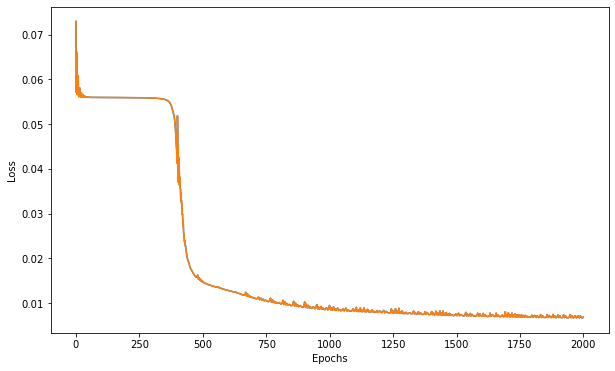

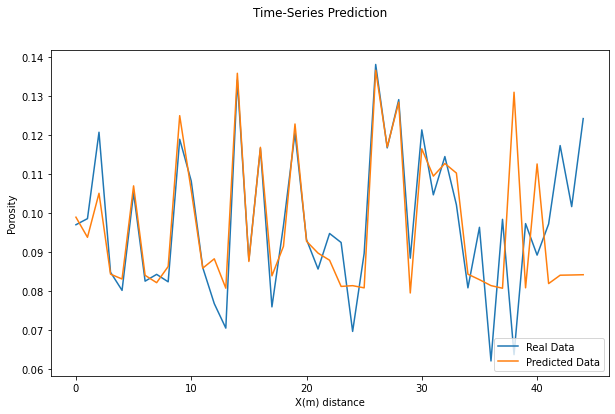

In [1278]:
training_set = pd.read_csv('datasets/scaled_v1_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.6292426595168857, pvalue=3.65845578076902e-06)
STD: 0.015455108
MSE: 0.00023948347


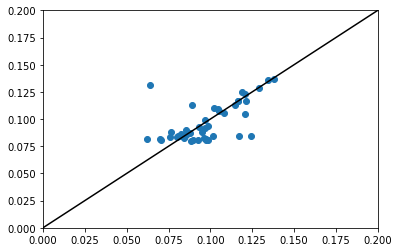

In [1279]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.27905
Epoch: 100, loss: 0.03221
Epoch: 200, loss: 0.03221
Epoch: 300, loss: 0.03221
Epoch: 400, loss: 0.03221
Epoch: 500, loss: 0.03221
Epoch: 600, loss: 0.03221
Epoch: 700, loss: 0.03221
Epoch: 800, loss: 0.03221
Epoch: 900, loss: 0.03221
Epoch: 1000, loss: 0.03221
Epoch: 1100, loss: 0.03221
Epoch: 1200, loss: 0.03221
Epoch: 1300, loss: 0.03220
Epoch: 1400, loss: 0.03220
Epoch: 1500, loss: 0.03220
Epoch: 1600, loss: 0.03220
Epoch: 1700, loss: 0.03219
Epoch: 1800, loss: 0.03219
Epoch: 1900, loss: 0.03218


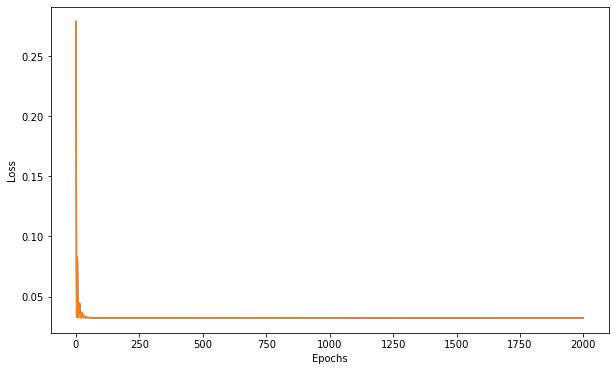

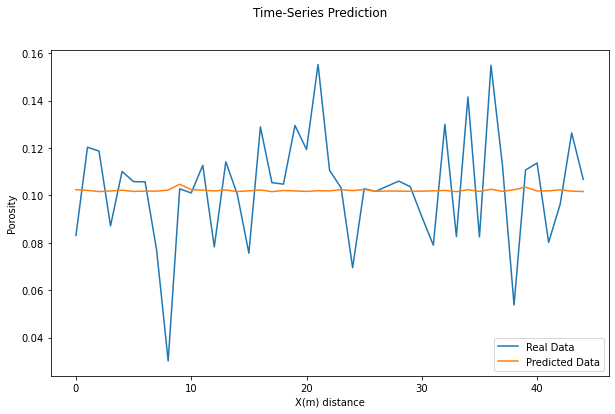

In [1280]:
training_set = pd.read_csv('datasets/scaled_v1_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.0586597658269224, pvalue=0.7018989411603243)
STD: 0.023377331
MSE: 0.0005471191


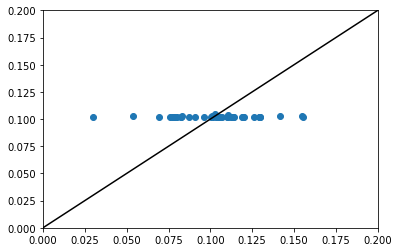

In [1281]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.518465956736729
Average MSE:  0.00027517572743818164


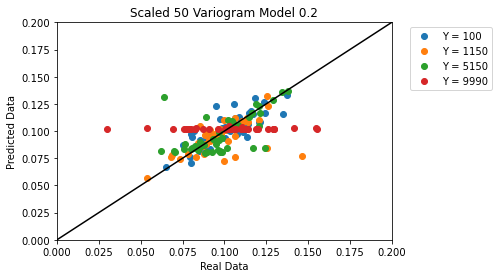

In [1282]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1283]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real1 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

## Variogram 0.4 Scaled 50

Epoch: 0, loss: 1.21892
Epoch: 100, loss: 0.02539
Epoch: 200, loss: 0.01807
Epoch: 300, loss: 0.00719
Epoch: 400, loss: 0.00661
Epoch: 500, loss: 0.00588
Epoch: 600, loss: 0.00565
Epoch: 700, loss: 0.00551
Epoch: 800, loss: 0.00533
Epoch: 900, loss: 0.00517
Epoch: 1000, loss: 0.00502
Epoch: 1100, loss: 0.00485
Epoch: 1200, loss: 0.00469
Epoch: 1300, loss: 0.00459
Epoch: 1400, loss: 0.00452
Epoch: 1500, loss: 0.00445
Epoch: 1600, loss: 0.00433
Epoch: 1700, loss: 0.00413
Epoch: 1800, loss: 0.00385
Epoch: 1900, loss: 0.00330


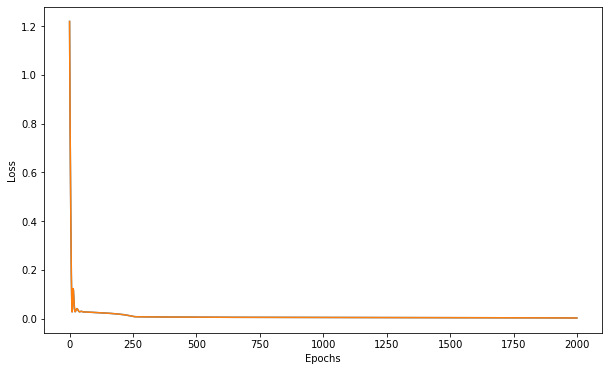

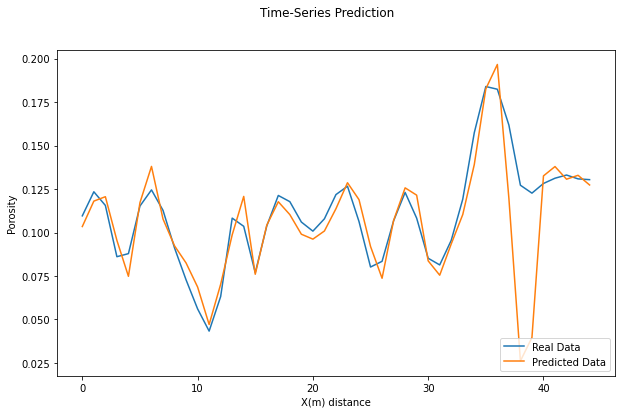

In [1284]:
training_set = pd.read_csv('datasets/scaled_v2_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.74843525115726, pvalue=3.4054616390294647e-09)
STD: 0.021496031
MSE: 0.00048294655


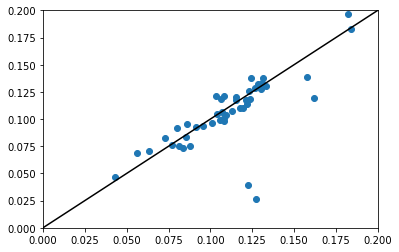

In [1285]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.09039
Epoch: 100, loss: 0.02110
Epoch: 200, loss: 0.01319
Epoch: 300, loss: 0.00934
Epoch: 400, loss: 0.00749
Epoch: 500, loss: 0.00663
Epoch: 600, loss: 0.00637
Epoch: 700, loss: 0.00619
Epoch: 800, loss: 0.00606
Epoch: 900, loss: 0.00593
Epoch: 1000, loss: 0.00580
Epoch: 1100, loss: 0.00568
Epoch: 1200, loss: 0.00556
Epoch: 1300, loss: 0.00546
Epoch: 1400, loss: 0.00536
Epoch: 1500, loss: 0.00527
Epoch: 1600, loss: 0.00520
Epoch: 1700, loss: 0.00515
Epoch: 1800, loss: 0.00512
Epoch: 1900, loss: 0.00510


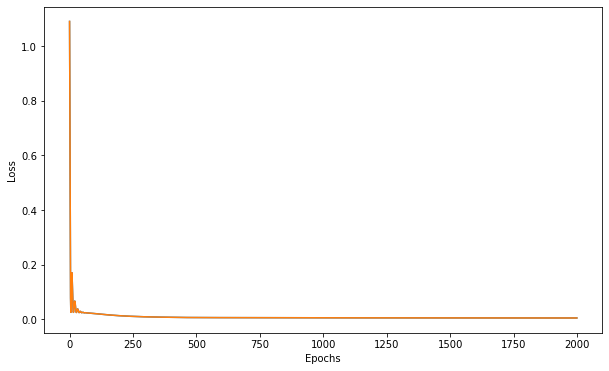

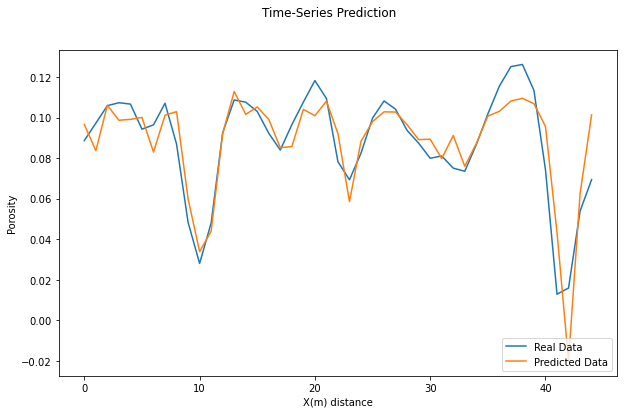

In [1286]:
training_set = pd.read_csv('datasets/scaled_v2_50_115.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8803950766898865, pvalue=1.5966335767539167e-15)
STD: 0.012367671
MSE: 0.00015296724


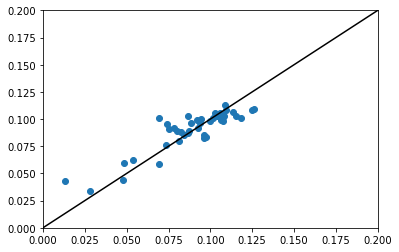

In [1287]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.22380
Epoch: 100, loss: 0.02308
Epoch: 200, loss: 0.00733
Epoch: 300, loss: 0.00653
Epoch: 400, loss: 0.00538
Epoch: 500, loss: 0.00509
Epoch: 600, loss: 0.00496
Epoch: 700, loss: 0.00483
Epoch: 800, loss: 0.00360
Epoch: 900, loss: 0.00205
Epoch: 1000, loss: 0.00203
Epoch: 1100, loss: 0.00190
Epoch: 1200, loss: 0.00181
Epoch: 1300, loss: 0.00164
Epoch: 1400, loss: 0.00146
Epoch: 1500, loss: 0.00135
Epoch: 1600, loss: 0.00126
Epoch: 1700, loss: 0.00124
Epoch: 1800, loss: 0.00112
Epoch: 1900, loss: 0.00115


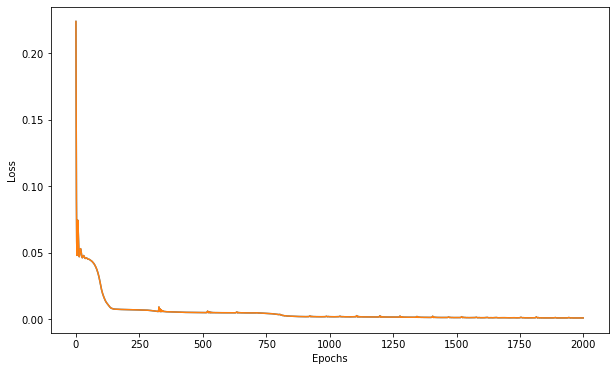

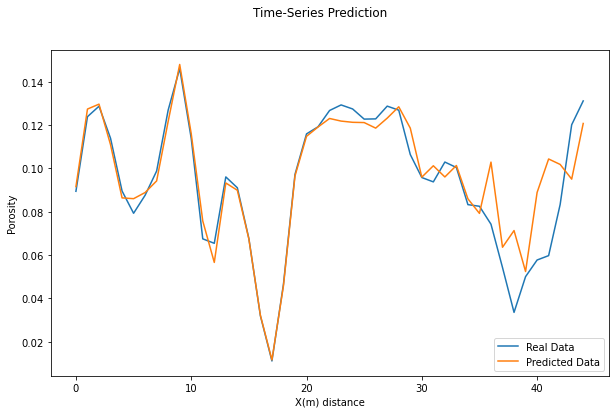

In [1288]:
training_set = pd.read_csv('datasets/scaled_v2_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9191121725683888, pvalue=5.293000272482907e-19)
STD: 0.0122909
MSE: 0.00015807804


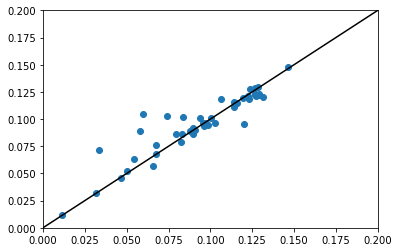

In [1289]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.92498
Epoch: 100, loss: 0.04933
Epoch: 200, loss: 0.02037
Epoch: 300, loss: 0.00888
Epoch: 400, loss: 0.00693
Epoch: 500, loss: 0.00631
Epoch: 600, loss: 0.00609
Epoch: 700, loss: 0.00592
Epoch: 800, loss: 0.00582
Epoch: 900, loss: 0.00574
Epoch: 1000, loss: 0.00564
Epoch: 1100, loss: 0.00553
Epoch: 1200, loss: 0.00537
Epoch: 1300, loss: 0.00517
Epoch: 1400, loss: 0.00500
Epoch: 1500, loss: 0.00490
Epoch: 1600, loss: 0.00506
Epoch: 1700, loss: 0.00478
Epoch: 1800, loss: 0.00474
Epoch: 1900, loss: 0.00471


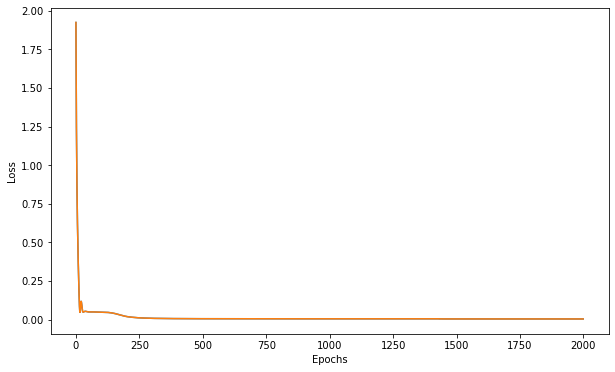

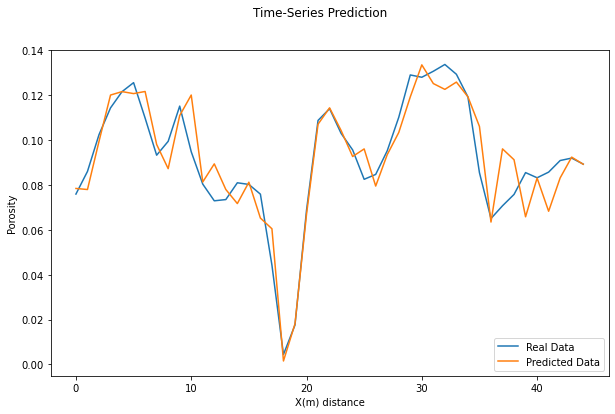

In [1290]:
training_set = pd.read_csv('datasets/scaled_v2_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9300411324494108, pvalue=2.6090675966853682e-20)
STD: 0.009991426
MSE: 0.00010004078


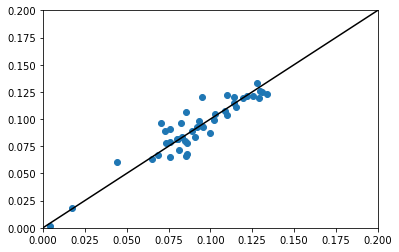

In [1291]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.8694959082162366
Average MSE:  0.0002235081628896296


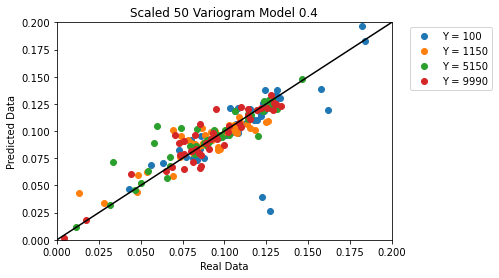

In [1292]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1293]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real2 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

## Variogram 0.6 Scaled 50 

Epoch: 0, loss: 0.02586
Epoch: 100, loss: 0.00390
Epoch: 200, loss: 0.00372
Epoch: 300, loss: 0.00348
Epoch: 400, loss: 0.00358
Epoch: 500, loss: 0.00310
Epoch: 600, loss: 0.00283
Epoch: 700, loss: 0.00243
Epoch: 800, loss: 0.00263
Epoch: 900, loss: 0.00199
Epoch: 1000, loss: 0.00182
Epoch: 1100, loss: 0.00177
Epoch: 1200, loss: 0.00162
Epoch: 1300, loss: 0.00207
Epoch: 1400, loss: 0.00140
Epoch: 1500, loss: 0.00125
Epoch: 1600, loss: 0.00116
Epoch: 1700, loss: 0.00106
Epoch: 1800, loss: 0.00094
Epoch: 1900, loss: 0.00093


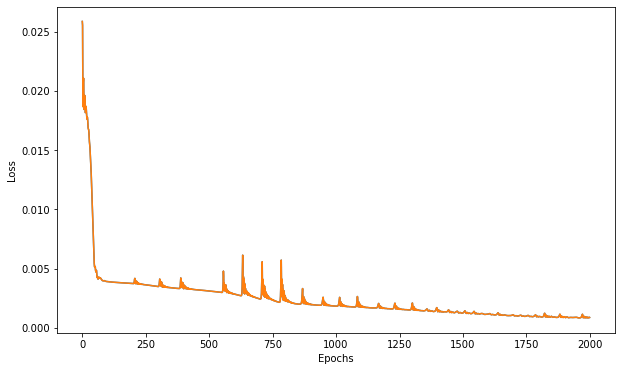

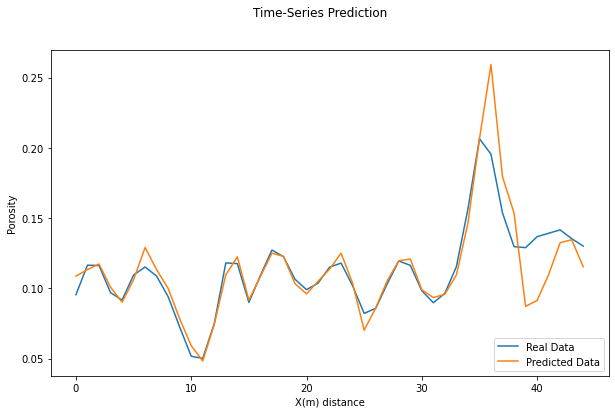

In [1294]:
training_set = pd.read_csv('datasets/scaled_v3_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8933615738006708, pvalue=1.548498161179263e-16)
STD: 0.015880285
MSE: 0.00025218452


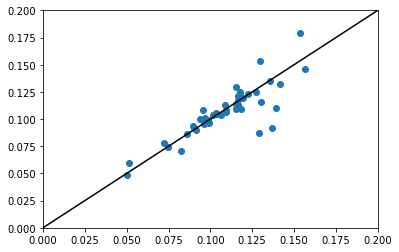

In [1295]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.10180
Epoch: 100, loss: 0.01118
Epoch: 200, loss: 0.00736
Epoch: 300, loss: 0.00668
Epoch: 400, loss: 0.00594
Epoch: 500, loss: 0.00506
Epoch: 600, loss: 0.00449
Epoch: 700, loss: 0.00424
Epoch: 800, loss: 0.00405
Epoch: 900, loss: 0.00388
Epoch: 1000, loss: 0.00372
Epoch: 1100, loss: 0.00393
Epoch: 1200, loss: 0.00335
Epoch: 1300, loss: 0.00330
Epoch: 1400, loss: 0.00286
Epoch: 1500, loss: 0.00245
Epoch: 1600, loss: 0.00337
Epoch: 1700, loss: 0.00209
Epoch: 1800, loss: 0.00195
Epoch: 1900, loss: 0.00197


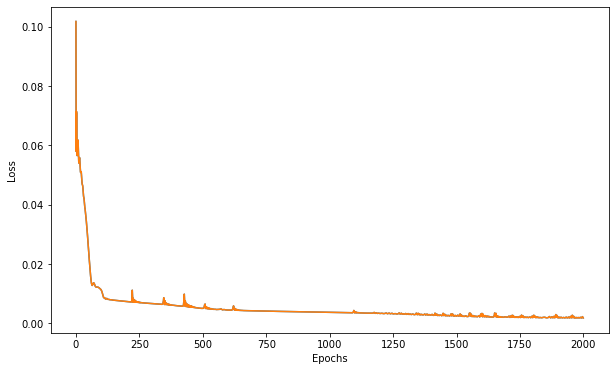

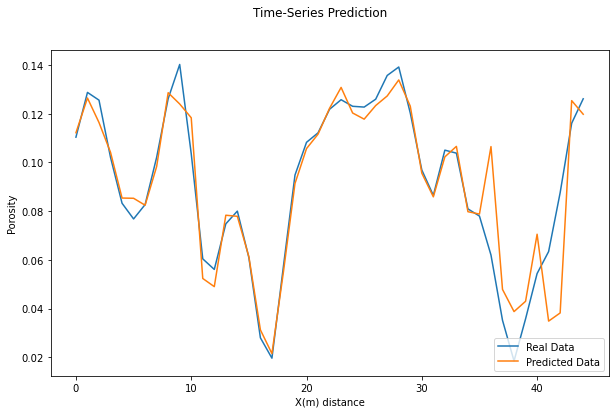

In [1296]:
training_set = pd.read_csv('datasets/scaled_v3_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9243091776065971, pvalue=1.338355985823532e-19)
STD: 0.01272695
MSE: 0.00016201784


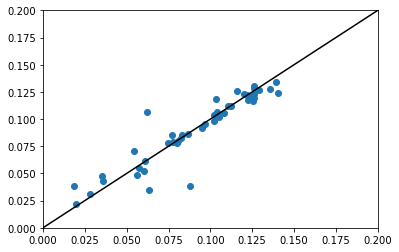

In [1297]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.33355
Epoch: 100, loss: 0.01373
Epoch: 200, loss: 0.00712
Epoch: 300, loss: 0.00629
Epoch: 400, loss: 0.00621
Epoch: 500, loss: 0.00615
Epoch: 600, loss: 0.00609
Epoch: 700, loss: 0.00602
Epoch: 800, loss: 0.00595
Epoch: 900, loss: 0.00567
Epoch: 1000, loss: 0.00518
Epoch: 1100, loss: 0.00507
Epoch: 1200, loss: 0.00497
Epoch: 1300, loss: 0.00485
Epoch: 1400, loss: 0.00464
Epoch: 1500, loss: 0.00453
Epoch: 1600, loss: 0.00445
Epoch: 1700, loss: 0.00438
Epoch: 1800, loss: 0.00431
Epoch: 1900, loss: 0.00425


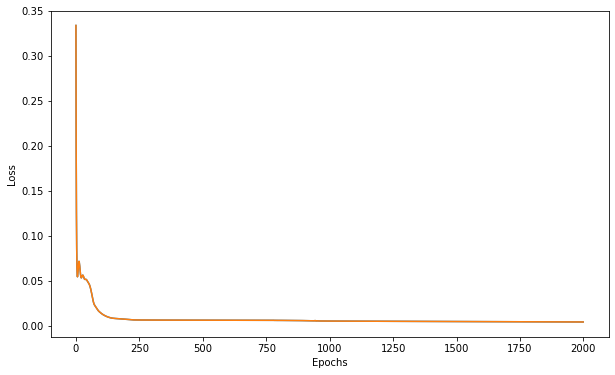

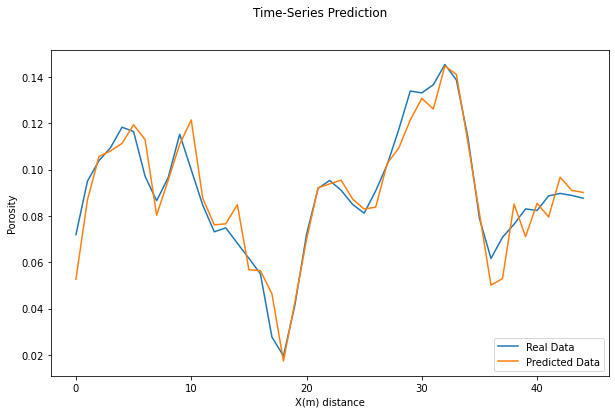

In [1298]:
training_set = pd.read_csv('datasets/scaled_v3_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9505409128830864, pvalue=1.8548573043798216e-23)
STD: 0.008408307
MSE: 7.105526e-05


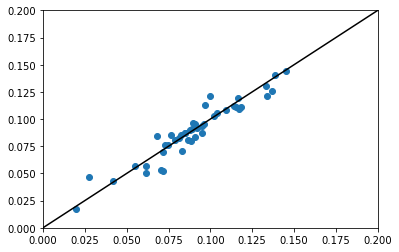

In [1299]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.9218309592146858
Average MSE:  0.00016083390801213682


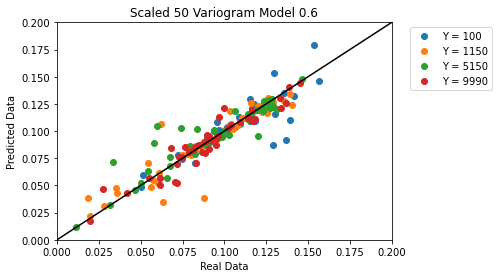

In [1300]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1301]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real3 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

## Variogram 0.8 Scale 50

Epoch: 0, loss: 0.30952
Epoch: 100, loss: 0.01616
Epoch: 200, loss: 0.00415
Epoch: 300, loss: 0.00369
Epoch: 400, loss: 0.00347
Epoch: 500, loss: 0.00328
Epoch: 600, loss: 0.00305
Epoch: 700, loss: 0.00275
Epoch: 800, loss: 0.00391
Epoch: 900, loss: 0.00206
Epoch: 1000, loss: 0.00161
Epoch: 1100, loss: 0.00138
Epoch: 1200, loss: 0.00125
Epoch: 1300, loss: 0.00121
Epoch: 1400, loss: 0.00113
Epoch: 1500, loss: 0.00110
Epoch: 1600, loss: 0.00108
Epoch: 1700, loss: 0.00106
Epoch: 1800, loss: 0.00104
Epoch: 1900, loss: 0.00103


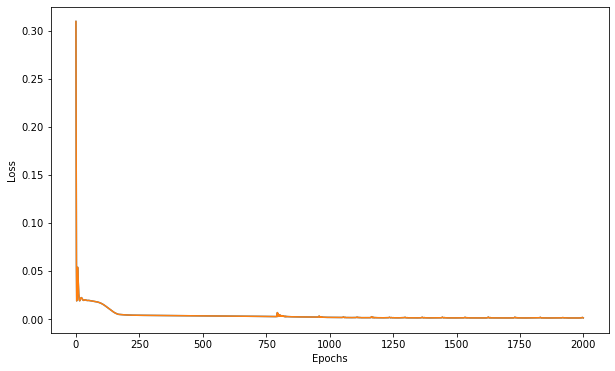

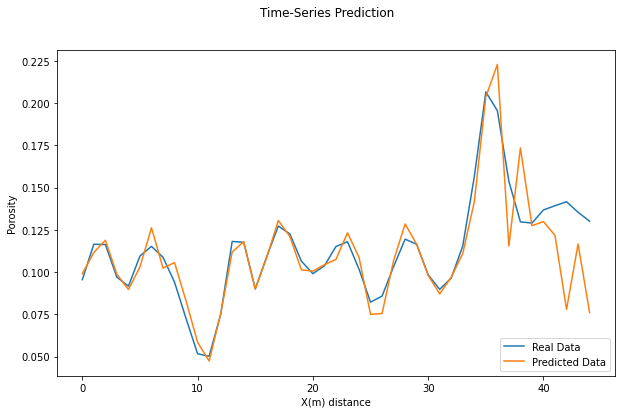

In [1302]:
training_set = pd.read_csv('datasets/scaled_v4_50_100.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8495951201109048, pvalue=1.5962548907307762e-13)
STD: 0.016782016
MSE: 0.00029097058


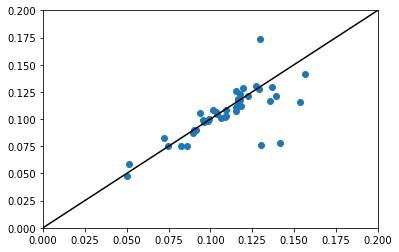

In [1303]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.05958
Epoch: 100, loss: 0.00678
Epoch: 200, loss: 0.00705
Epoch: 300, loss: 0.00540
Epoch: 400, loss: 0.00480
Epoch: 500, loss: 0.00375
Epoch: 600, loss: 0.00310
Epoch: 700, loss: 0.00251
Epoch: 800, loss: 0.00234
Epoch: 900, loss: 0.00380
Epoch: 1000, loss: 0.00210
Epoch: 1100, loss: 0.00192
Epoch: 1200, loss: 0.00178
Epoch: 1300, loss: 0.00202
Epoch: 1400, loss: 0.00223
Epoch: 1500, loss: 0.00145
Epoch: 1600, loss: 0.00158
Epoch: 1700, loss: 0.00125
Epoch: 1800, loss: 0.00129
Epoch: 1900, loss: 0.00133


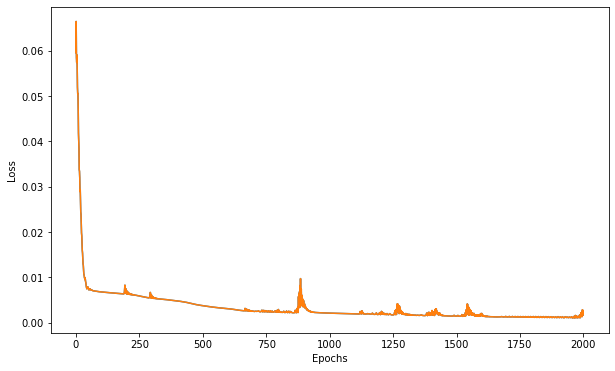

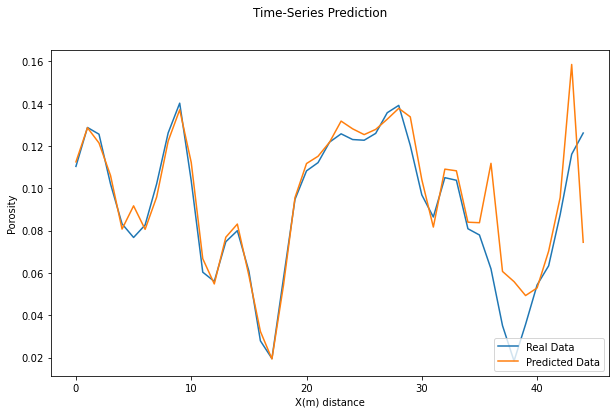

In [1304]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9013206352422932, pvalue=3.170706804458001e-17)
STD: 0.014428933
MSE: 0.00022789862


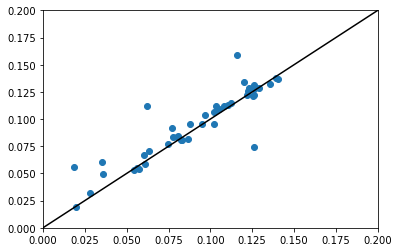

In [1305]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.32480
Epoch: 100, loss: 0.04405
Epoch: 200, loss: 0.00836
Epoch: 300, loss: 0.00675
Epoch: 400, loss: 0.00521
Epoch: 500, loss: 0.00473
Epoch: 600, loss: 0.00429
Epoch: 700, loss: 0.00380
Epoch: 800, loss: 0.00344
Epoch: 900, loss: 0.00313
Epoch: 1000, loss: 0.00277
Epoch: 1100, loss: 0.00257
Epoch: 1200, loss: 0.00243
Epoch: 1300, loss: 0.00233
Epoch: 1400, loss: 0.00230
Epoch: 1500, loss: 0.00316
Epoch: 1600, loss: 0.00210
Epoch: 1700, loss: 0.00204
Epoch: 1800, loss: 0.00251
Epoch: 1900, loss: 0.00192


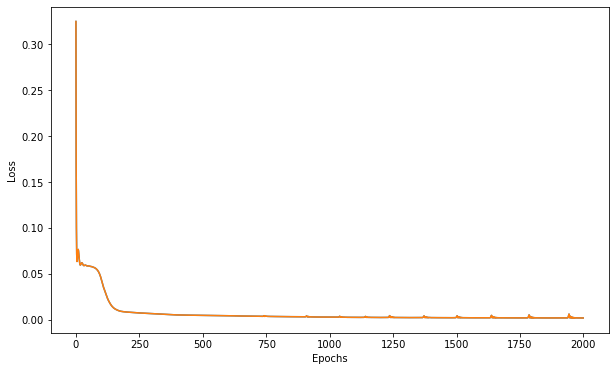

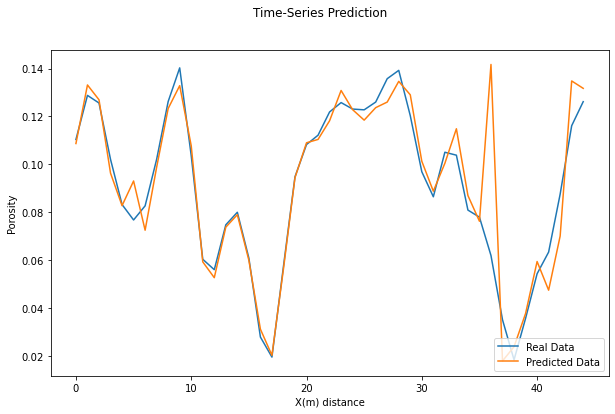

In [1306]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9180644088813575, pvalue=6.906292988332006e-19)
STD: 0.013802237
MSE: 0.0001923379


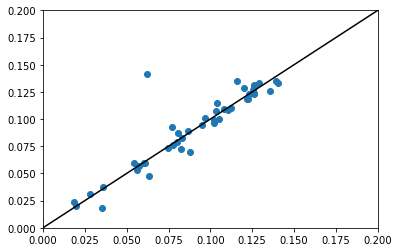

In [1307]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.17751
Epoch: 100, loss: 0.01041
Epoch: 200, loss: 0.00765
Epoch: 300, loss: 0.00707
Epoch: 400, loss: 0.00654
Epoch: 500, loss: 0.00635
Epoch: 600, loss: 0.00625
Epoch: 700, loss: 0.00618
Epoch: 800, loss: 0.00609
Epoch: 900, loss: 0.00597
Epoch: 1000, loss: 0.00577
Epoch: 1100, loss: 0.00542
Epoch: 1200, loss: 0.00483
Epoch: 1300, loss: 0.00443
Epoch: 1400, loss: 0.00427
Epoch: 1500, loss: 0.00415
Epoch: 1600, loss: 0.00398
Epoch: 1700, loss: 0.00372
Epoch: 1800, loss: 0.00345
Epoch: 1900, loss: 0.00318


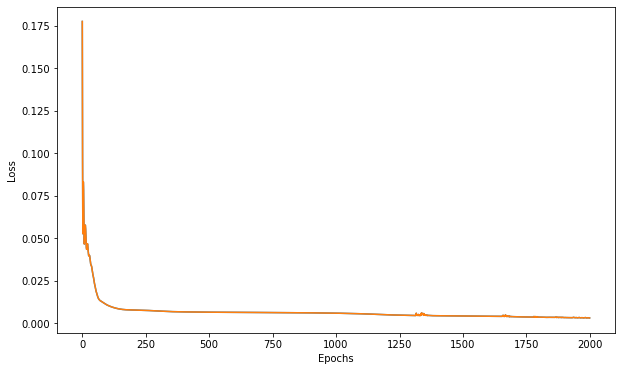

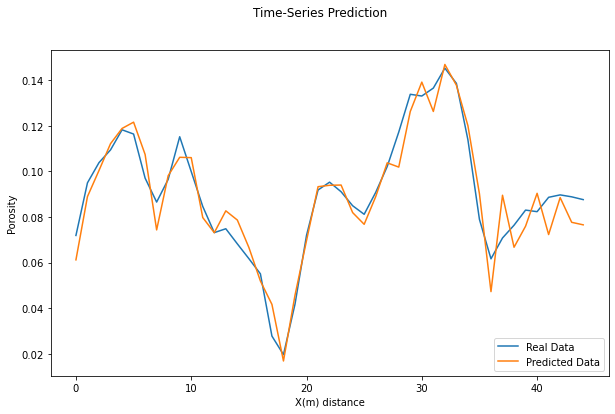

In [1308]:
training_set = pd.read_csv('datasets/scaled_v4_50_999.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.06

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.25

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.954912475466972, pvalue=2.649958719855924e-24)
STD: 0.008044835
MSE: 6.569577e-05


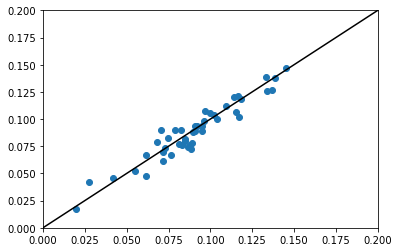

In [1309]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new4 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse4 = mse(dataY_plot[:,0], data_predict[:,0])
real_d4 = dataY_plot[:,0]
pred_d4 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.905973159925382
Average MSE:  0.00019422572222538292


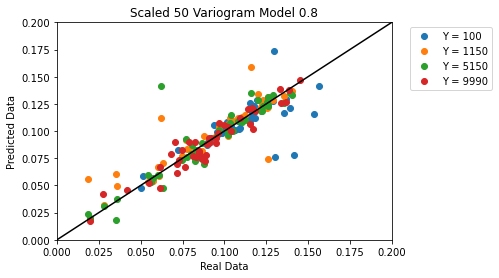

In [1310]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 100')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 1150')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 5150')
plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0]) / 4
mse_02_n = (mse1 + mse2 + mse3 + mse4) / 4
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 50 Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1311]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3, pred_d4))
real4 = np.concatenate((real_d1, real_d2, real_d3, real_d4))

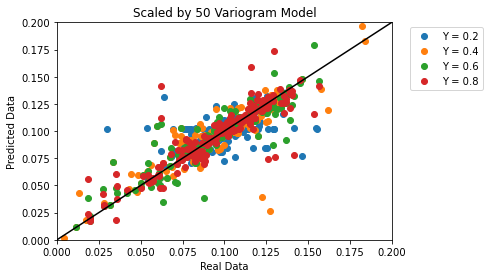

In [1312]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Scaled by 50 Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Scaled 20

In [1313]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        
        return out

Epoch: 0, loss: 0.22146
Epoch: 100, loss: 0.04817
Epoch: 200, loss: 0.02223
Epoch: 300, loss: 0.01817
Epoch: 400, loss: 0.01716
Epoch: 500, loss: 0.01655
Epoch: 600, loss: 0.01314
Epoch: 700, loss: 0.01254
Epoch: 800, loss: 0.01244
Epoch: 900, loss: 0.01239
Epoch: 1000, loss: 0.01235
Epoch: 1100, loss: 0.01233
Epoch: 1200, loss: 0.01231
Epoch: 1300, loss: 0.01229
Epoch: 1400, loss: 0.01228
Epoch: 1500, loss: 0.01226
Epoch: 1600, loss: 0.01226
Epoch: 1700, loss: 0.01224
Epoch: 1800, loss: 0.01223
Epoch: 1900, loss: 0.01227


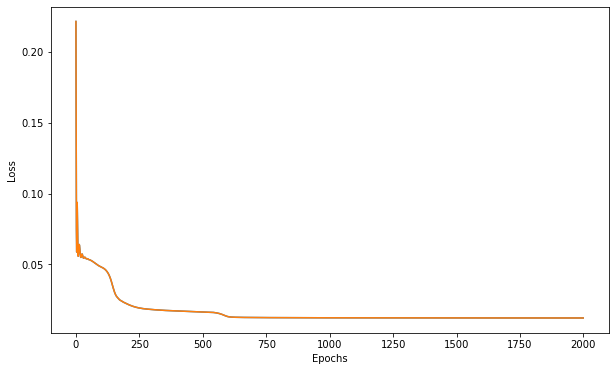

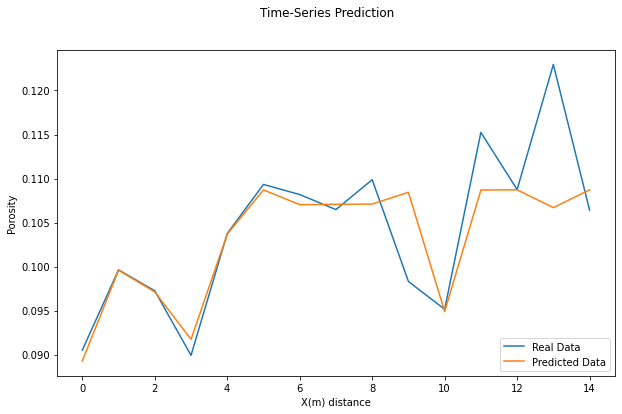

In [1314]:
training_set = pd.read_csv('datasets/scaled_v1_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8016049428565193, pvalue=0.000326156908514048)
STD: 0.005266687
MSE: 2.8638407e-05


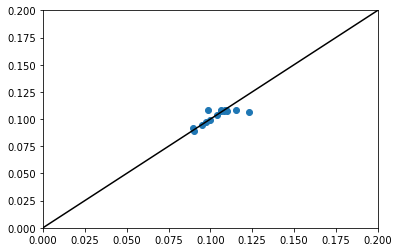

In [1315]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.49357
Epoch: 100, loss: 0.03421
Epoch: 200, loss: 0.03356
Epoch: 300, loss: 0.03324
Epoch: 400, loss: 0.03299
Epoch: 500, loss: 0.03278
Epoch: 600, loss: 0.03256
Epoch: 700, loss: 0.03228
Epoch: 800, loss: 0.03187
Epoch: 900, loss: 0.03105
Epoch: 1000, loss: 0.02943
Epoch: 1100, loss: 0.02433
Epoch: 1200, loss: 0.01317
Epoch: 1300, loss: 0.01229
Epoch: 1400, loss: 0.00756
Epoch: 1500, loss: 0.00542
Epoch: 1600, loss: 0.00450
Epoch: 1700, loss: 0.00380
Epoch: 1800, loss: 0.00331
Epoch: 1900, loss: 0.00387


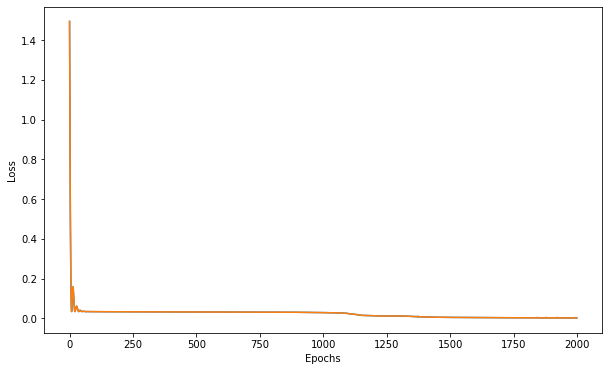

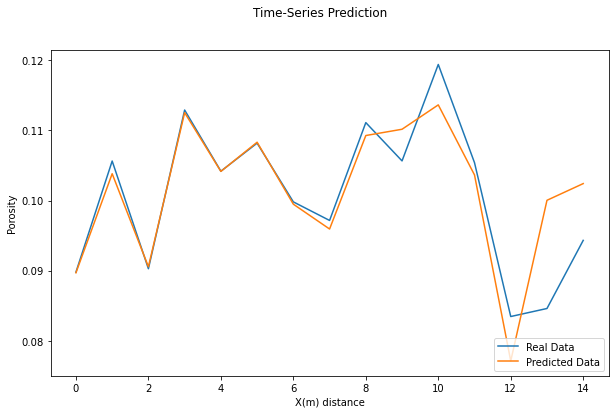

In [1316]:
training_set = pd.read_csv('datasets/scaled_v1_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8653763732160593, pvalue=3.0861119081643555e-05)
STD: 0.0051892865
MSE: 2.7281283e-05


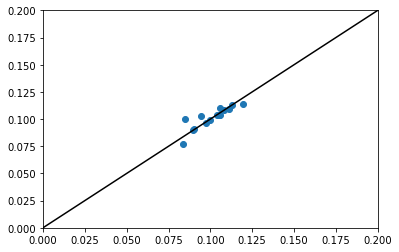

In [1317]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.17013
Epoch: 100, loss: 0.08815
Epoch: 200, loss: 0.08119
Epoch: 300, loss: 0.08026
Epoch: 400, loss: 0.08003
Epoch: 500, loss: 0.07994
Epoch: 600, loss: 0.07989
Epoch: 700, loss: 0.07985
Epoch: 800, loss: 0.07983
Epoch: 900, loss: 0.07982
Epoch: 1000, loss: 0.07981
Epoch: 1100, loss: 0.07980
Epoch: 1200, loss: 0.07979
Epoch: 1300, loss: 0.07979
Epoch: 1400, loss: 0.07978
Epoch: 1500, loss: 0.07978
Epoch: 1600, loss: 0.07978
Epoch: 1700, loss: 0.07978
Epoch: 1800, loss: 0.07977
Epoch: 1900, loss: 0.07977


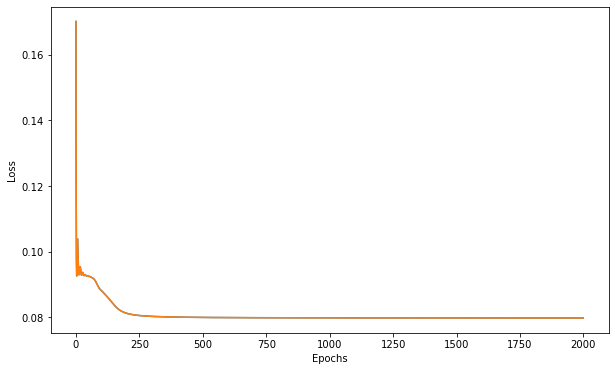

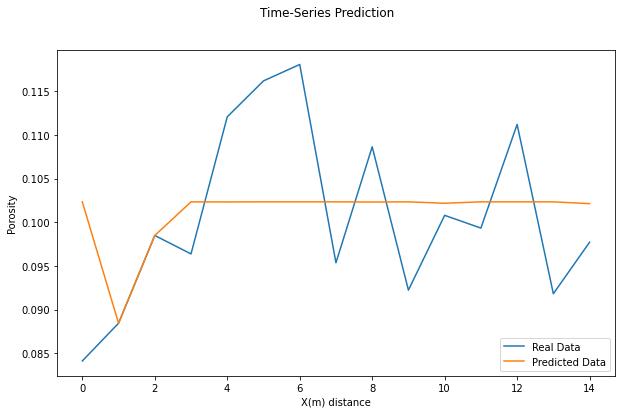

In [1318]:
training_set = pd.read_csv('datasets/scaled_v1_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.07

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.3419329408154119, pvalue=0.2122374591198228)
STD: 0.009349163
MSE: 8.7570894e-05


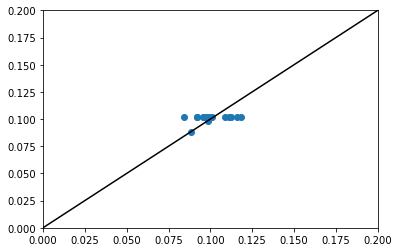

In [1319]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.6696380856293302
Average MSE:  4.783019539900124e-05


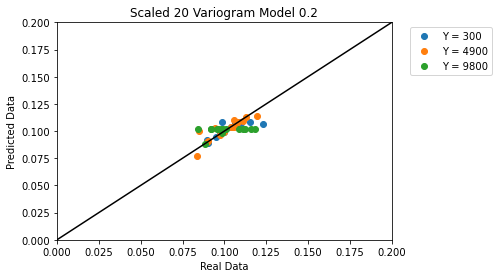

In [1320]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1321]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3))
real1 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.4 Scale 10

Epoch: 0, loss: 0.99841
Epoch: 100, loss: 0.03083
Epoch: 200, loss: 0.03081
Epoch: 300, loss: 0.03080
Epoch: 400, loss: 0.03080
Epoch: 500, loss: 0.03080
Epoch: 600, loss: 0.03079
Epoch: 700, loss: 0.03079
Epoch: 800, loss: 0.03079
Epoch: 900, loss: 0.03077
Epoch: 1000, loss: 0.03117
Epoch: 1100, loss: 0.03079
Epoch: 1200, loss: 0.03079
Epoch: 1300, loss: 0.03079


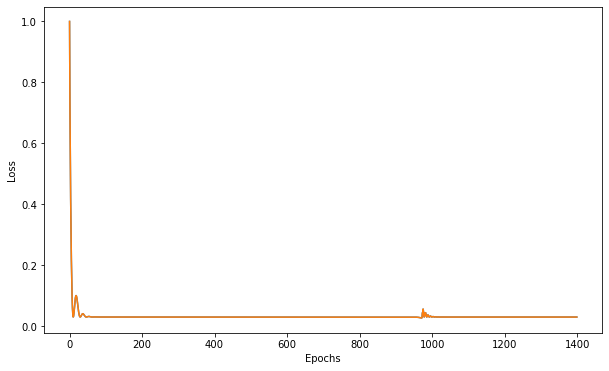

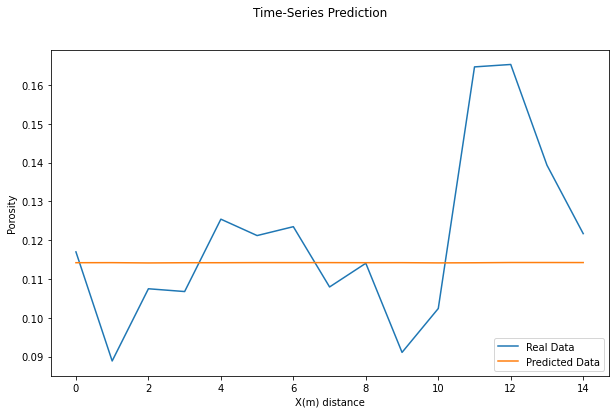

In [1322]:
training_set = pd.read_csv('datasets/scaled_v2_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.32940780063384206, pvalue=0.230552662722902)
STD: 0.021764228
MSE: 0.0005047748


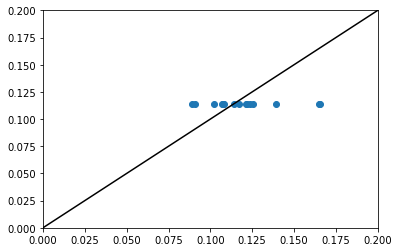

In [1323]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.67983
Epoch: 100, loss: 0.04847
Epoch: 200, loss: 0.04583
Epoch: 300, loss: 0.03816
Epoch: 400, loss: 0.03696
Epoch: 500, loss: 0.03397
Epoch: 600, loss: 0.02294
Epoch: 700, loss: 0.01529
Epoch: 800, loss: 0.01193
Epoch: 900, loss: 0.01021
Epoch: 1000, loss: 0.00121
Epoch: 1100, loss: 0.00012
Epoch: 1200, loss: 0.00007
Epoch: 1300, loss: 0.00004


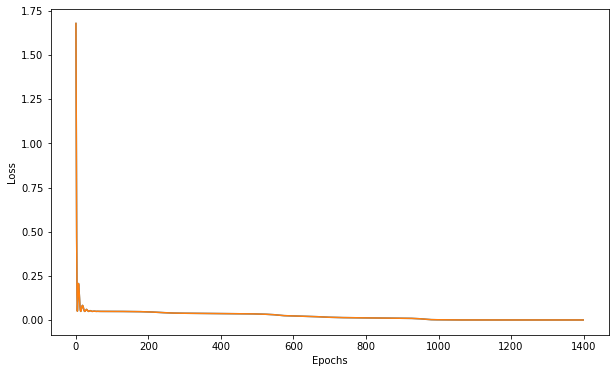

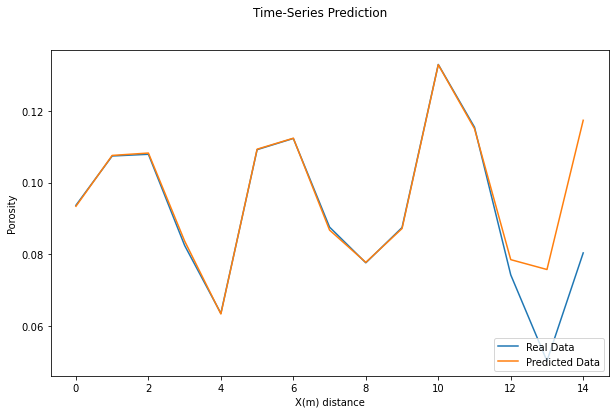

In [1324]:
training_set = pd.read_csv('datasets/scaled_v2_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8620782337314115, pvalue=3.582025056275111e-05)
STD: 0.010769096
MSE: 0.0001357466


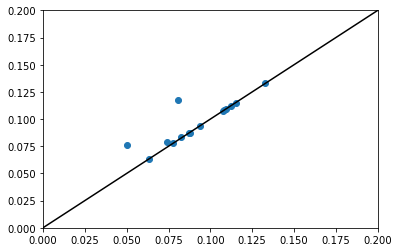

In [1325]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.89921
Epoch: 100, loss: 0.05305
Epoch: 200, loss: 0.04813
Epoch: 300, loss: 0.04151
Epoch: 400, loss: 0.03464
Epoch: 500, loss: 0.02417
Epoch: 600, loss: 0.02120
Epoch: 700, loss: 0.02021
Epoch: 800, loss: 0.01889
Epoch: 900, loss: 0.01663
Epoch: 1000, loss: 0.01605
Epoch: 1100, loss: 0.01135
Epoch: 1200, loss: 0.00821
Epoch: 1300, loss: 0.00515


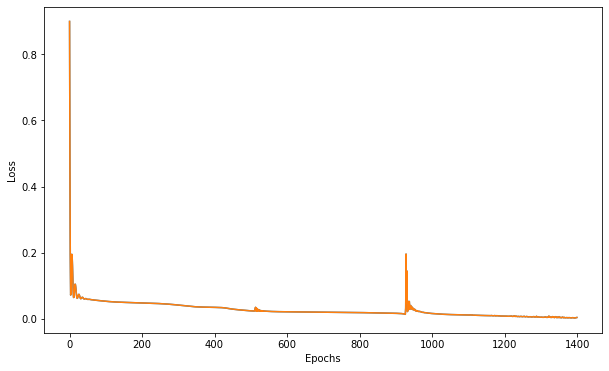

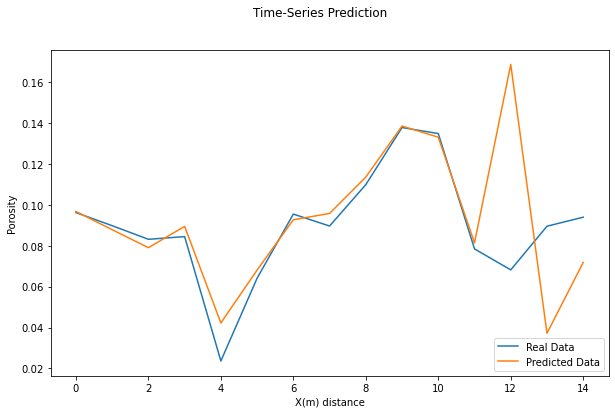

In [1326]:
training_set = pd.read_csv('datasets/scaled_v2_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2


lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.5205860152429741, pvalue=0.0466358145713291)
STD: 0.030128935
MSE: 0.0009222123


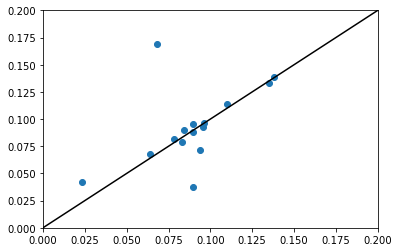

In [1327]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.5706906832027426
Average MSE:  0.000520911222944657


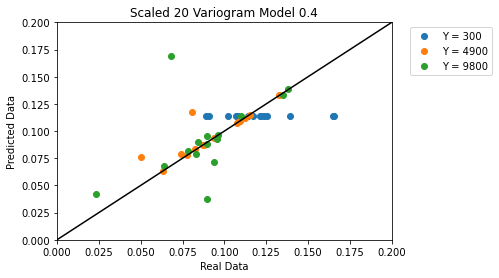

In [1328]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1329]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3))
real2 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.6 Scale 20

Epoch: 0, loss: 0.19917
Epoch: 100, loss: 0.02202
Epoch: 200, loss: 0.02199
Epoch: 300, loss: 0.02197
Epoch: 400, loss: 0.02195
Epoch: 500, loss: 0.02191
Epoch: 600, loss: 0.02177
Epoch: 700, loss: 0.02073
Epoch: 800, loss: 0.02118
Epoch: 900, loss: 0.01872
Epoch: 1000, loss: 0.01799
Epoch: 1100, loss: 0.01765
Epoch: 1200, loss: 0.01599
Epoch: 1300, loss: 0.02211


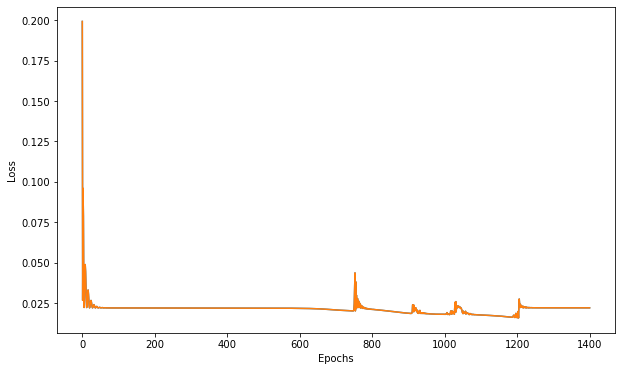

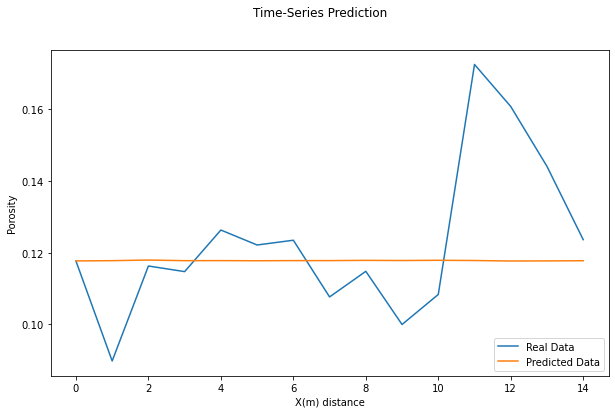

In [1330]:
training_set = pd.read_csv('datasets/scaled_v3_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.32882615811621135, pvalue=0.23142639682876803)
STD: 0.021047872
MSE: 0.00046826436


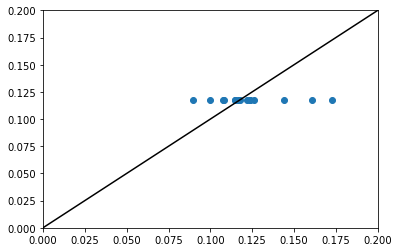

In [1331]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.27299
Epoch: 100, loss: 0.03390
Epoch: 200, loss: 0.03356
Epoch: 300, loss: 0.03323
Epoch: 400, loss: 0.03264
Epoch: 500, loss: 0.03217
Epoch: 600, loss: 0.03177
Epoch: 700, loss: 0.03126
Epoch: 800, loss: 0.03034
Epoch: 900, loss: 0.02823
Epoch: 1000, loss: 0.02304
Epoch: 1100, loss: 0.01994
Epoch: 1200, loss: 0.01455
Epoch: 1300, loss: 0.01204


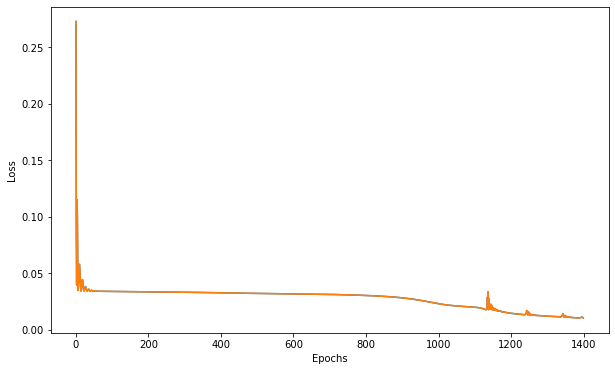

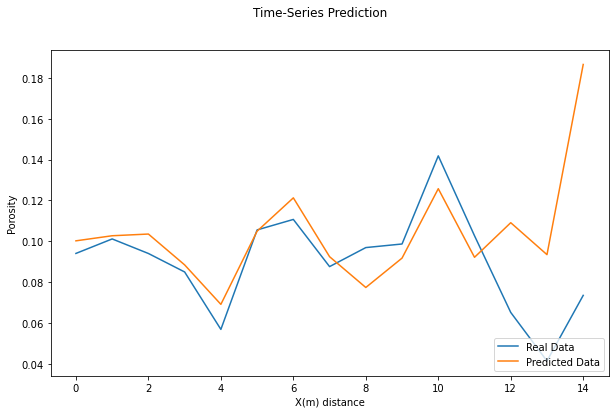

In [1332]:
training_set = pd.read_csv('datasets/scaled_v3_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.14289897664939846, pvalue=0.6114168315515472)
STD: 0.032557297
MSE: 0.0012447365


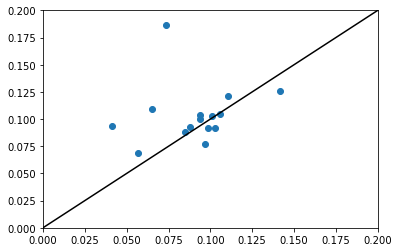

In [1333]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.07730
Epoch: 100, loss: 0.03700
Epoch: 200, loss: 0.03177
Epoch: 300, loss: 0.02621
Epoch: 400, loss: 0.01837
Epoch: 500, loss: 0.00833
Epoch: 600, loss: 0.00322
Epoch: 700, loss: 0.00226
Epoch: 800, loss: 0.00188
Epoch: 900, loss: 0.00539
Epoch: 1000, loss: 0.00137
Epoch: 1100, loss: 0.00132
Epoch: 1200, loss: 0.00097
Epoch: 1300, loss: 0.00088


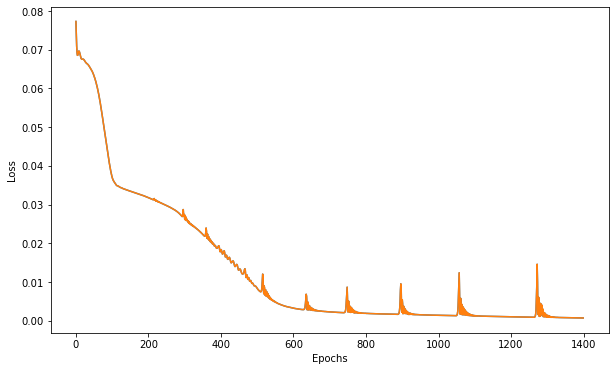

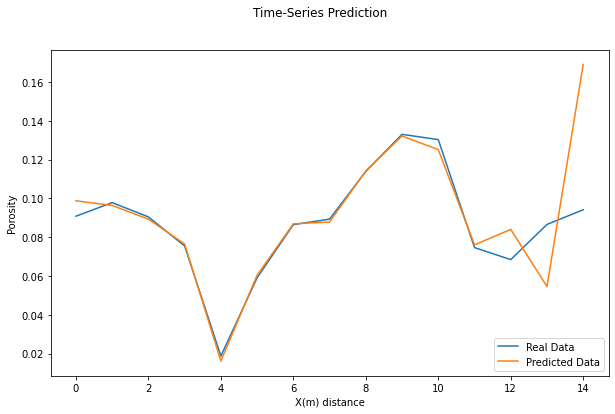

In [1334]:
training_set = pd.read_csv('datasets/scaled_v3_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.7895694828818283, pvalue=0.0004635928042833698)
STD: 0.021224517
MSE: 0.0004655579


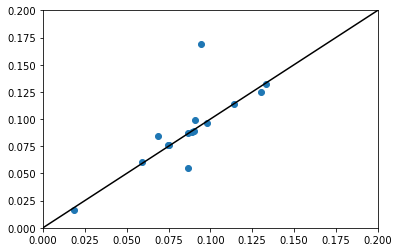

In [1335]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.42062542005502296
Average MSE:  0.0007383564176658789


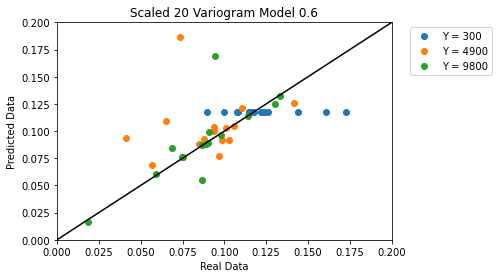

In [1336]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1337]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3))
real3 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.8 Scale 20

Epoch: 0, loss: 0.11405
Epoch: 100, loss: 0.02143
Epoch: 200, loss: 0.02120
Epoch: 300, loss: 0.02099
Epoch: 400, loss: 0.02091
Epoch: 500, loss: 0.02084
Epoch: 600, loss: 0.02076
Epoch: 700, loss: 0.02064
Epoch: 800, loss: 0.02031
Epoch: 900, loss: 0.01900


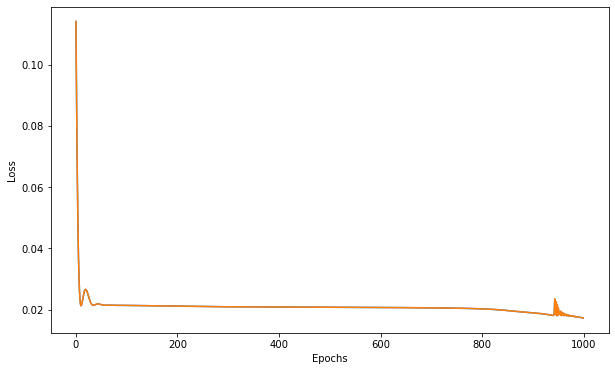

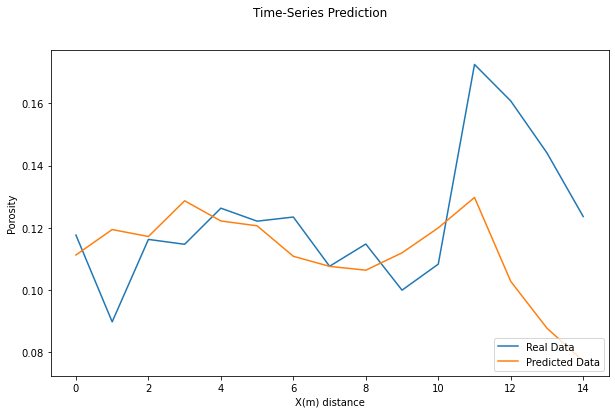

In [1338]:
training_set = pd.read_csv('datasets/scaled_v4_20_300.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.09124267318846091, pvalue=0.7463928349196532)
STD: 0.026179072
MSE: 0.0008113059


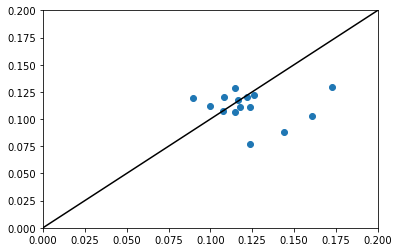

In [1339]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.07709
Epoch: 100, loss: 0.03437
Epoch: 200, loss: 0.03416
Epoch: 300, loss: 0.03395
Epoch: 400, loss: 0.03368
Epoch: 500, loss: 0.03330
Epoch: 600, loss: 0.03286
Epoch: 700, loss: 0.03237
Epoch: 800, loss: 0.03175
Epoch: 900, loss: 0.03049
Epoch: 1000, loss: 0.02708
Epoch: 1100, loss: 0.02229
Epoch: 1200, loss: 0.01684
Epoch: 1300, loss: 0.00601


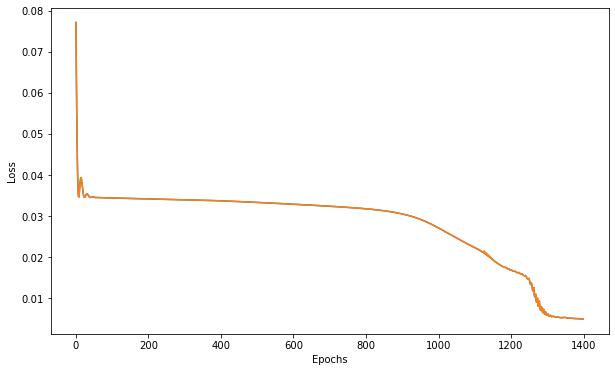

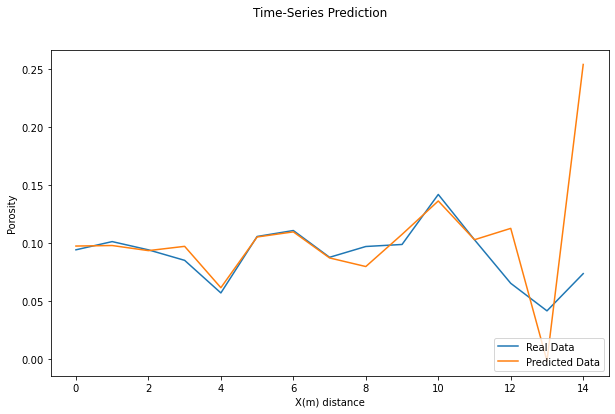

In [1340]:
training_set = pd.read_csv('datasets/scaled_v4_20_490.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1400
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.31081769025140005, pvalue=0.2595004755797781)
STD: 0.048335165
MSE: 0.0024870683


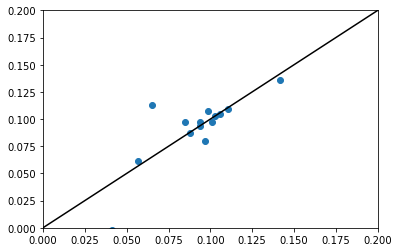

In [1341]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.29276
Epoch: 100, loss: 0.06161
Epoch: 200, loss: 0.05200
Epoch: 300, loss: 0.04265
Epoch: 400, loss: 0.03163
Epoch: 500, loss: 0.02639
Epoch: 600, loss: 0.02385
Epoch: 700, loss: 0.02217
Epoch: 800, loss: 0.01894
Epoch: 900, loss: 0.01225


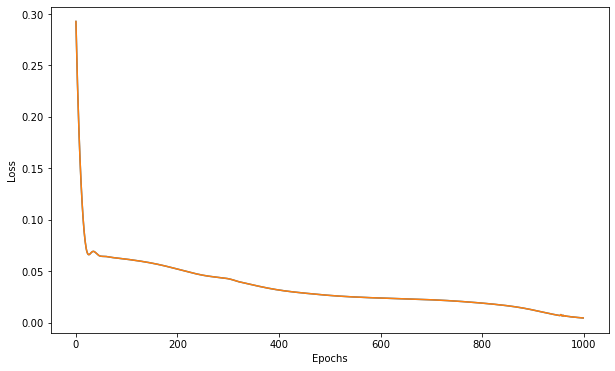

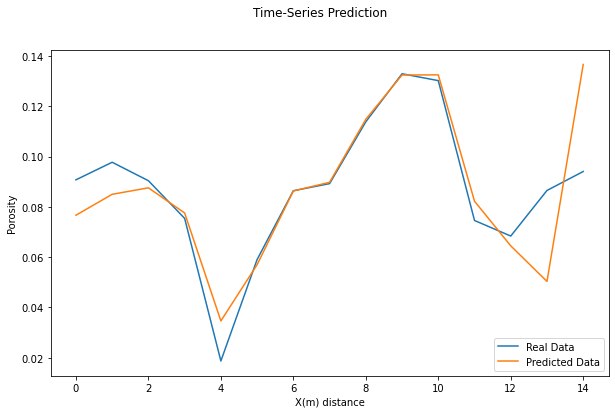

In [1342]:
training_set = pd.read_csv('datasets/scaled_v4_20_980.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8440394548652854, pvalue=7.608348708898968e-05)
STD: 0.015995601
MSE: 0.00025585954


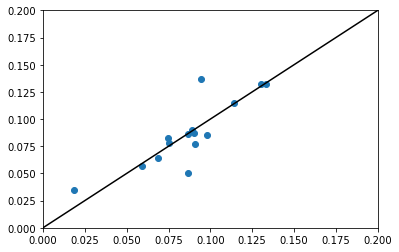

In [1343]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.3545381573094082
Average MSE:  0.0011847445275634527


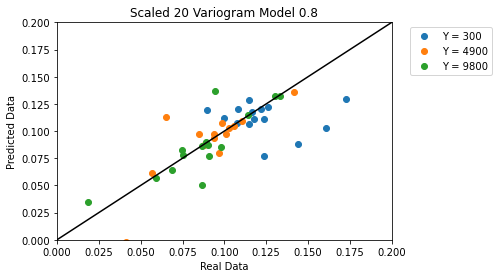

In [1344]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 20 Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1345]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3))
real4 = np.concatenate((real_d1, real_d2, real_d3))

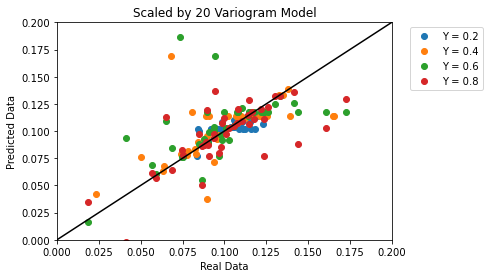

In [1346]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Scaled by 20 Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Scale 10

In [1347]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [1348]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        #self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        
        return out

Epoch: 0, loss: 1.30089
Epoch: 100, loss: 0.02597
Epoch: 200, loss: 0.02589
Epoch: 300, loss: 0.02580


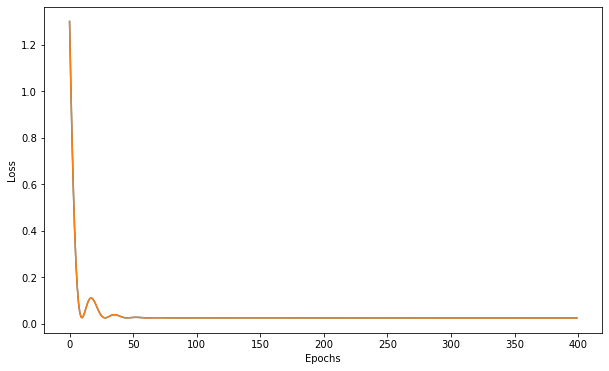

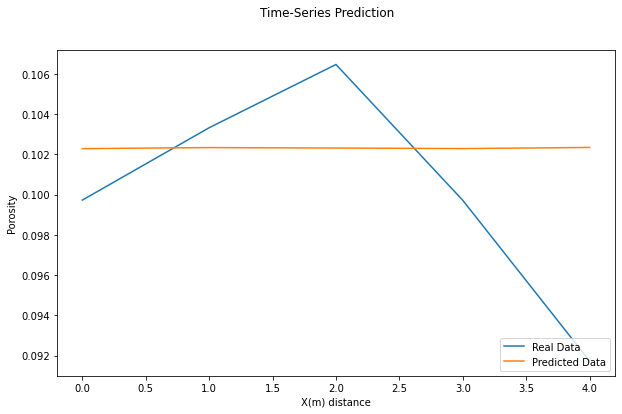

In [1349]:
training_set = pd.read_csv('datasets/scaled_v1_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.2555025061884657, pvalue=0.6782591197908757)
STD: 0.0049321875
MSE: 2.882533e-05


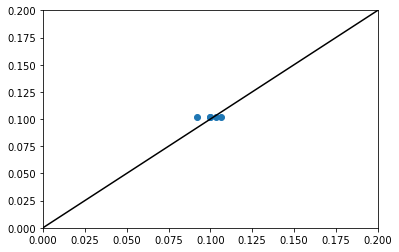

In [1350]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.14951
Epoch: 100, loss: 0.05497
Epoch: 200, loss: 0.03411
Epoch: 300, loss: 0.02206


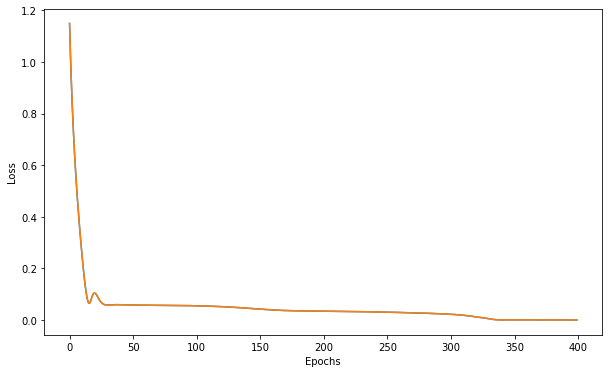

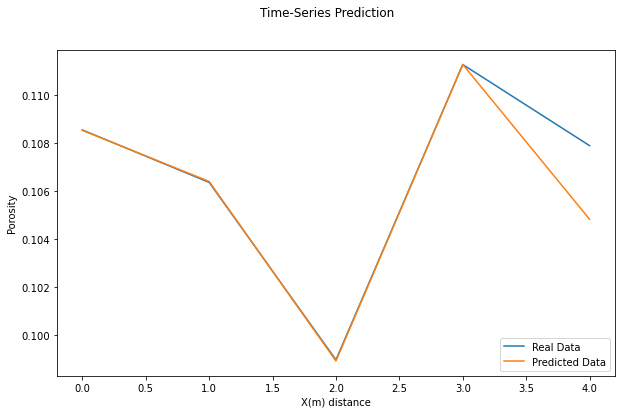

In [1351]:
training_set = pd.read_csv('datasets/scaled_v1_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9562348025146687, pvalue=0.010918310432939731)
STD: 0.0012258551
MSE: 1.8843873e-06


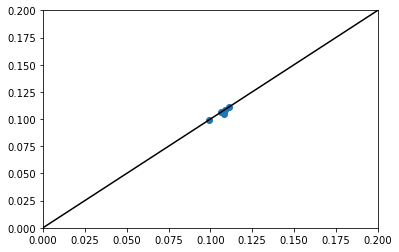

In [1352]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 1.74775
Epoch: 100, loss: 0.05833
Epoch: 200, loss: 0.05773
Epoch: 300, loss: 0.05686


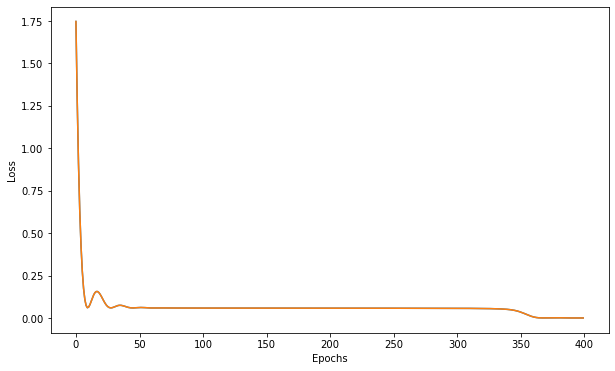

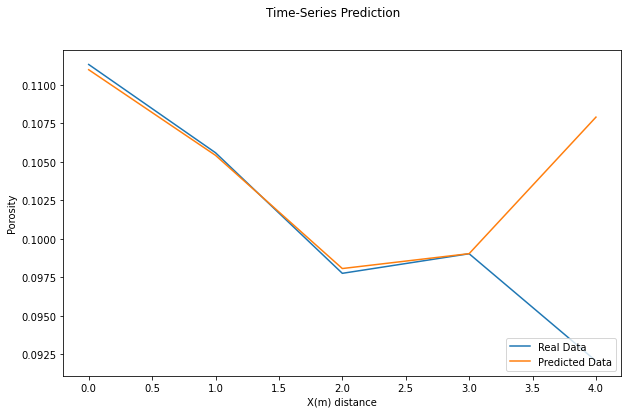

In [1353]:
training_set = pd.read_csv('datasets/scaled_v1_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.4348032409477862, pvalue=0.4643664777395281)
STD: 0.0063650026
MSE: 5.0323586e-05


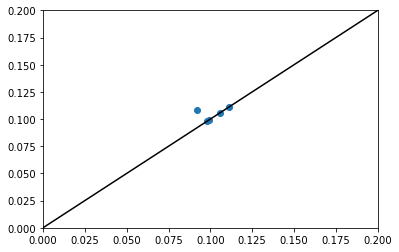

In [1354]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.3785118457579964
Average MSE:  2.701110012518863e-05


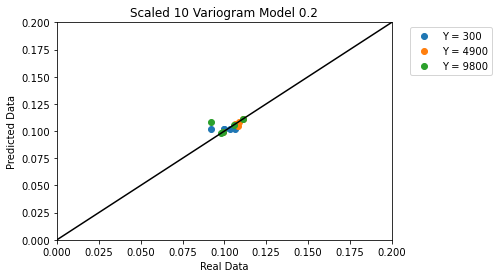

In [1355]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.2")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1356]:
con1 = np.concatenate((pred_d1, pred_d2, pred_d3))
real1 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.4 Scale 10

Epoch: 0, loss: 0.43604
Epoch: 100, loss: 0.00477
Epoch: 200, loss: 0.00476
Epoch: 300, loss: 0.00475


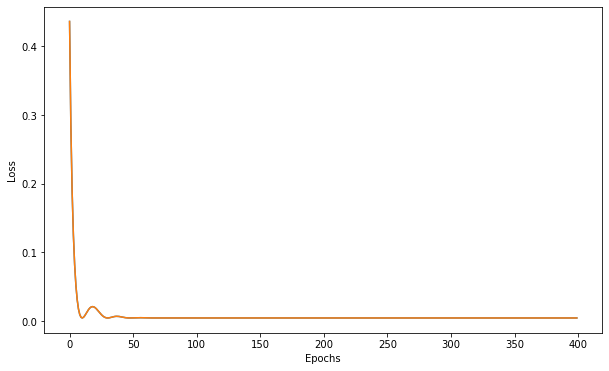

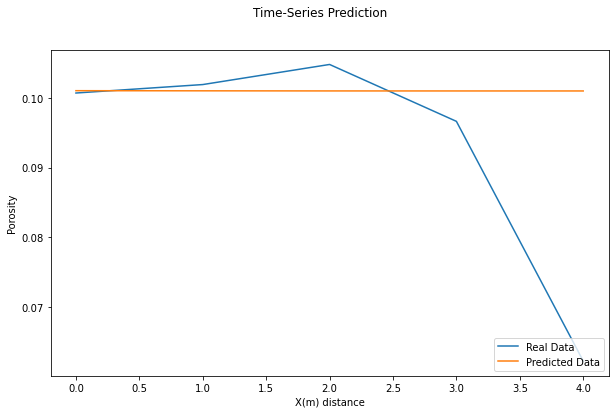

In [1357]:
training_set = pd.read_csv('datasets/scaled_v2_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.4487238566301838, pvalue=0.4484656671185255)
STD: 0.015702805
MSE: 0.00030650778


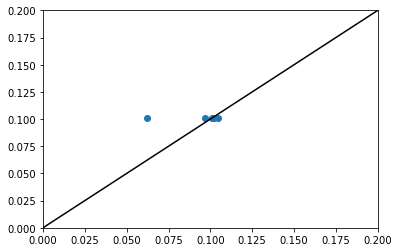

In [1358]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.14307
Epoch: 100, loss: 0.00013
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


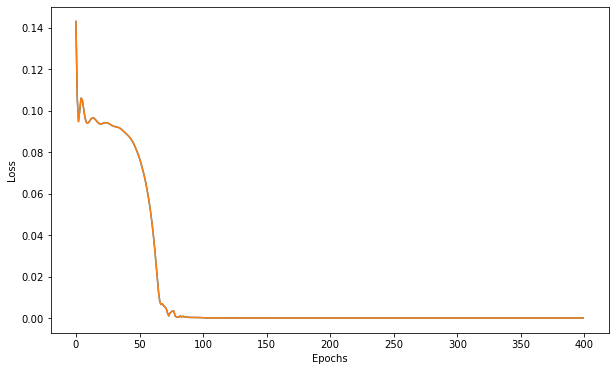

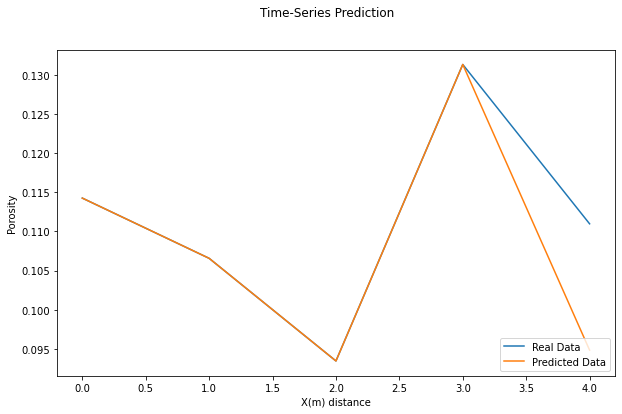

In [1359]:
training_set = pd.read_csv('datasets/scaled_v2_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8862243683074068, pvalue=0.04527449269140466)
STD: 0.006450332
MSE: 5.200871e-05


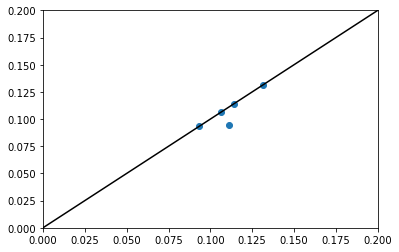

In [1360]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.17678
Epoch: 100, loss: 0.00005
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


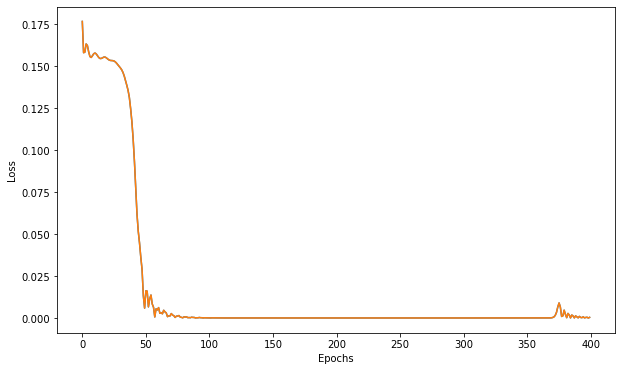

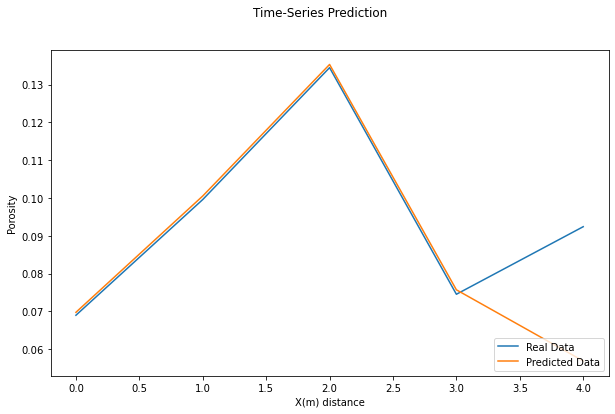

In [1361]:
training_set = pd.read_csv('datasets/scaled_v2_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8508610802873537, pvalue=0.06757065836690272)
STD: 0.014595927
MSE: 0.00025353621


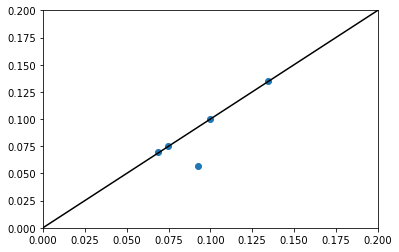

In [1362]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.7286031017416481
Average MSE:  0.00020401757986595234


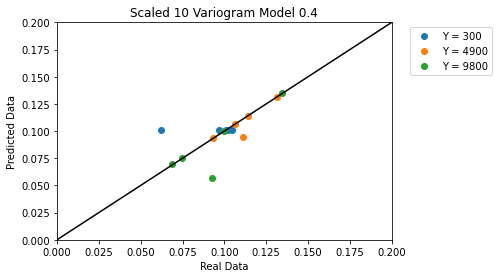

In [1363]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.4")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1364]:
con2 = np.concatenate((pred_d1, pred_d2, pred_d3))
real2 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.6 Scale 10

Epoch: 0, loss: 1.36924
Epoch: 100, loss: 0.01214
Epoch: 200, loss: 0.01202
Epoch: 300, loss: 0.01195


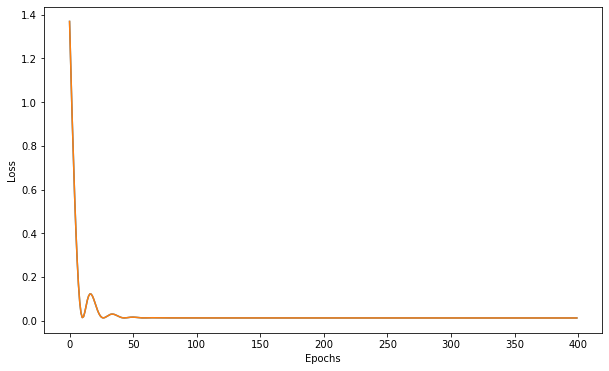

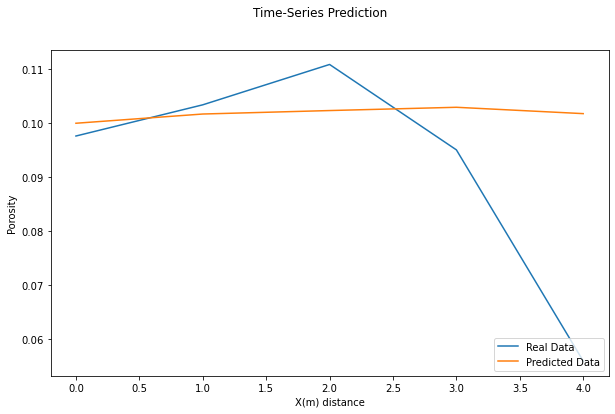

In [1365]:
training_set = pd.read_csv('datasets/scaled_v3_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.03802961755492413, pvalue=0.9515908610392739)
STD: 0.01910539
MSE: 0.00044913837


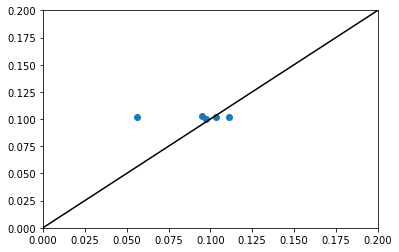

In [1366]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.58221
Epoch: 100, loss: 0.07763
Epoch: 200, loss: 0.01795
Epoch: 300, loss: 0.01113


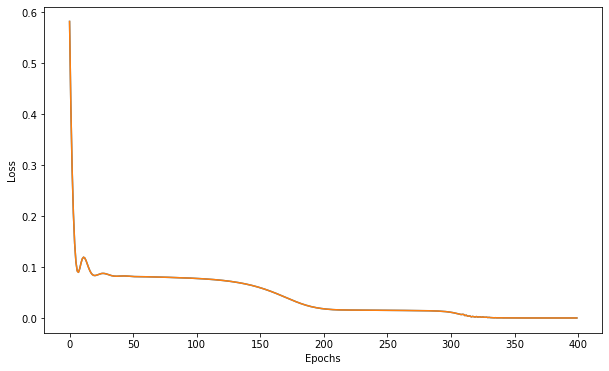

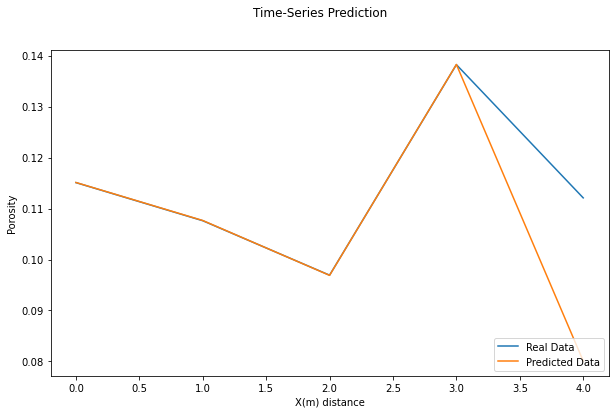

In [1367]:
training_set = pd.read_csv('datasets/scaled_v3_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.750485091585396, pvalue=0.14388525376382744)
STD: 0.012811639
MSE: 0.0002049427


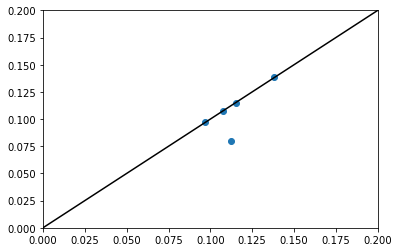

In [1368]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.16114
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


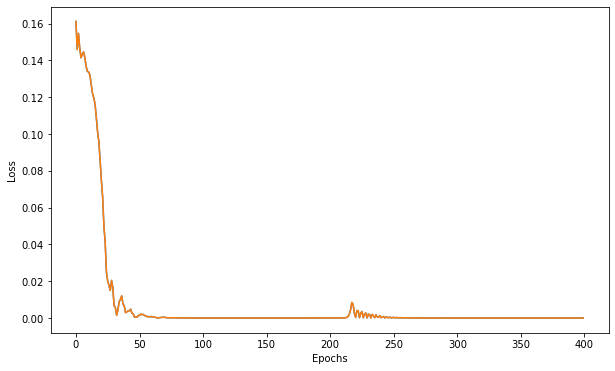

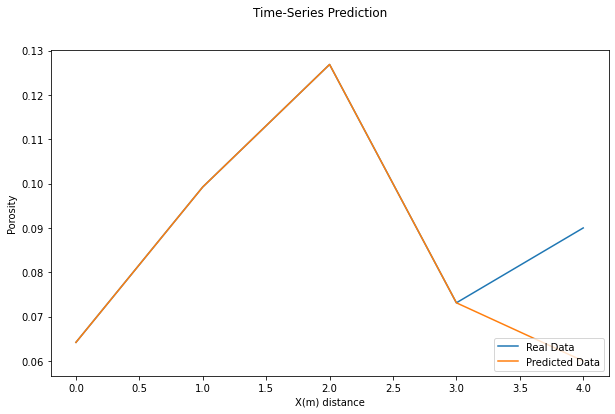

In [1369]:
training_set = pd.read_csv('datasets/scaled_v3_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.8785213800367054, pvalue=0.049889304763756845)
STD: 0.012004269
MSE: 0.0001801358


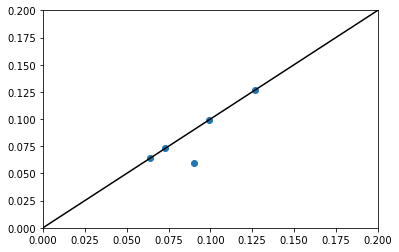

In [1370]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.5556786963923419
Average MSE:  0.0002780722764631112


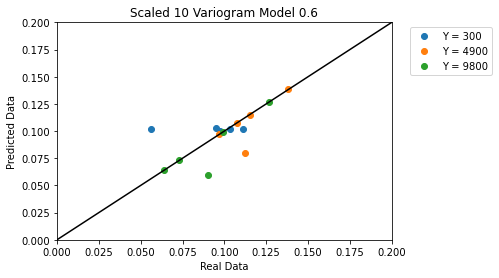

In [1371]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 300')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4900')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9800')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.6")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1372]:
con3 = np.concatenate((pred_d1, pred_d2, pred_d3))
real3 = np.concatenate((real_d1, real_d2, real_d3))

## Variogram 0.8 Scale 10

Epoch: 0, loss: 1.44242
Epoch: 100, loss: 0.01231
Epoch: 200, loss: 0.01228
Epoch: 300, loss: 0.01226


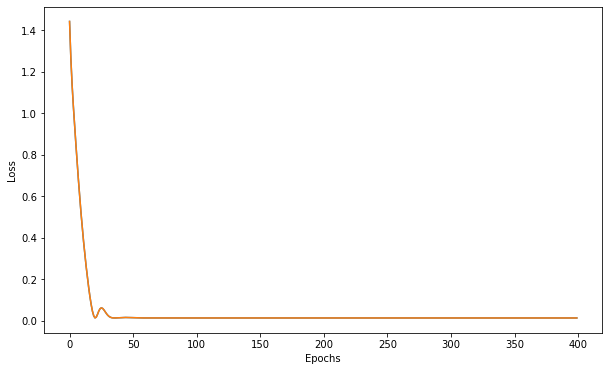

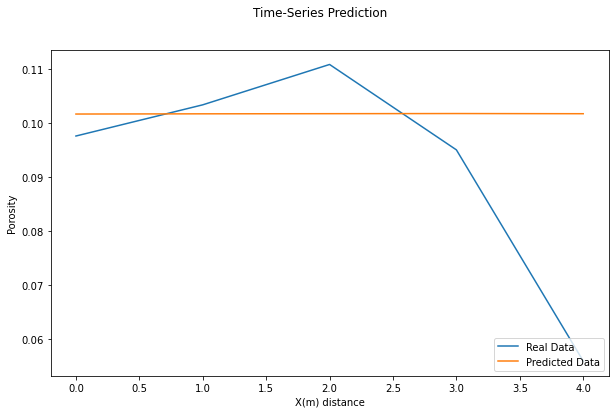

In [1373]:
training_set = pd.read_csv('datasets/scaled_v4_10_495.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=-0.11305177184600594, pvalue=0.8563652172924967)
STD: 0.019120883
MSE: 0.00044967575


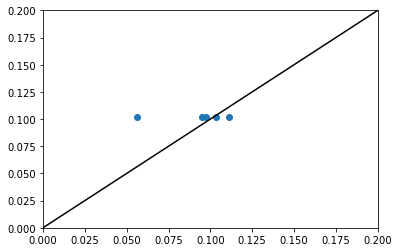

In [1374]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new1 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse1 = mse(dataY_plot[:,0], data_predict[:,0])
real_d1 = dataY_plot[:,0]
pred_d1 = data_predict[:,0] 
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.39031
Epoch: 100, loss: 0.03059
Epoch: 200, loss: 0.00645
Epoch: 300, loss: 0.00001


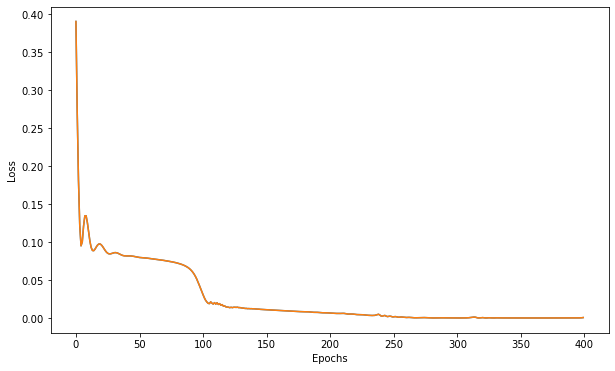

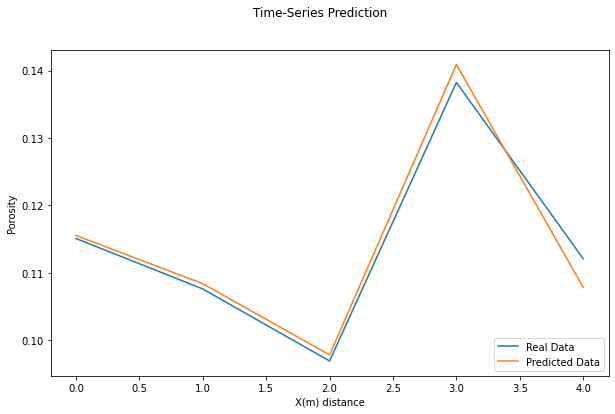

In [1375]:
training_set = pd.read_csv('datasets/scaled_v4_10_700.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9887172764698693, pvalue=0.0014362115246572653)
STD: 0.0023127003
MSE: 5.3608137e-06


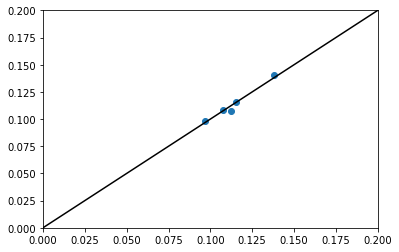

In [1376]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new2 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse2 = mse(dataY_plot[:,0], data_predict[:,0])
real_d2 = dataY_plot[:,0]
pred_d2 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Epoch: 0, loss: 0.20867
Epoch: 100, loss: 0.00026
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000


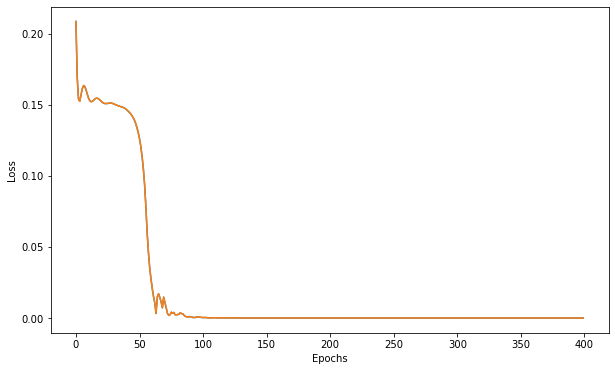

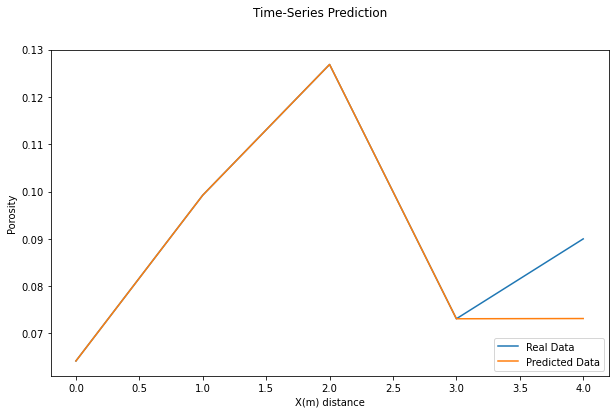

In [1377]:
training_set = pd.read_csv('datasets/scaled_v4_10_970.csv')
training_set = training_set.iloc[:,2:3].values


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 400
learning_rate = 0.05

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm.eval()
train_predict = lstm(dataX)
#fig, axs = plt.subplots(1, 1)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.xlabel('X(m) distance')
plt.ylabel('Porosity')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')

plt.legend(["Real Data", "Predicted Data"], loc ="lower right")
plt.show()

Pearson: PearsonRResult(statistic=0.9561545393058025, pvalue=0.010948225923624355)
STD: 0.0067366464
MSE: 5.6728684e-05


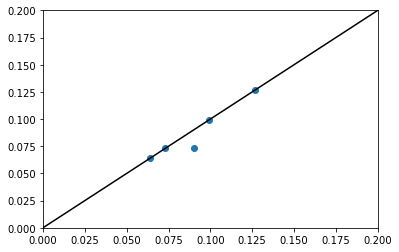

In [1379]:
plt.plot(dataY_plot[:,0], data_predict[:,0], 'o')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
new3 = pearsonr(dataY_plot[:,0], data_predict[:,0])
mse3 = mse(dataY_plot[:,0], data_predict[:,0])
real_d3 = dataY_plot[:,0]
pred_d3 = data_predict[:,0]
print('Pearson:',pearsonr(dataY_plot[:,0], data_predict[:,0]))
print('STD:',np.std(dataY_plot[:,0] - data_predict[:,0]))
from sklearn.metrics import mean_squared_error as mse
print('MSE:',mse(dataY_plot[:,0], data_predict[:,0]))

Average Pearson:  0.6106066813098886
Average MSE:  0.0001705884157369534


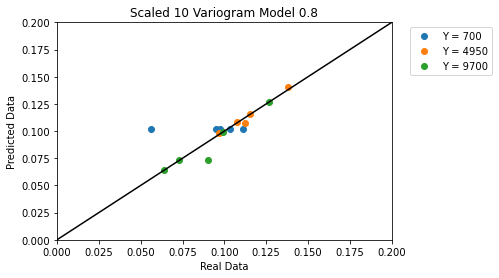

In [1380]:
plt.plot(real_d1, pred_d1, 'o', label = 'Y = 700')
plt.plot(real_d2, pred_d2, 'o', label = 'Y = 4950')
plt.plot(real_d3, pred_d3, 'o', label = 'Y = 9700')
#plt.plot(real_d4, pred_d4, 'o', label = 'Y = 9990')
#plt.plot(real_d5, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
pearson_02_n = (new1[0] + new2[0] + new3[0]) / 3
mse_02_n = (mse1 + mse2 + mse3) / 3
print('Average Pearson: ', pearson_02_n)
print('Average MSE: ', mse_02_n)
plt.title("Scaled 10 Variogram Model 0.8")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [1381]:
con4 = np.concatenate((pred_d1, pred_d2, pred_d3))
real4 = np.concatenate((real_d1, real_d2, real_d3))

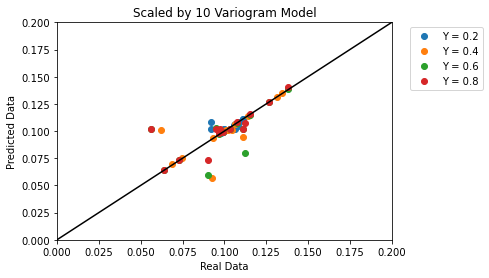

In [1382]:
plt.plot(real1, con1, 'o', label = 'Y = 0.2')
plt.plot(real2, con2, 'o', label = 'Y = 0.4')
plt.plot(real3, con3, 'o', label = 'Y = 0.6')
plt.plot(real4, con4, 'o', label = 'Y = 0.8')
#plt.plot(real1, pred_d5, 'o', label = 'Y = 9900')
plt.ylim(0,0.2)
plt.xlim(0,0.2)
plt.plot([0,1],[0,1],'k-')
#pearson_02_n = (new1[0] + new2[0] + new3[0] + new4[0] + new5[0]) / 5
#mse_02_n = (mse1 + mse2 + mse3 + mse4 + mse5) / 5
#print('Average Pearson: ', pearson_02_n)
#print('Average MSE: ', mse_02_n)
plt.title("Scaled by 10 Variogram Model")
plt.xlabel("Real Data")
plt.ylabel("Predicted Data")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")